# AI Resume Analyzer — Training & NER Pipeline
### ML Domain Classification  |  NER Entity Extraction  |  Combined Pipeline Demo
---

## Pipeline Architecture
```
Resume Input
     │
     ├──► Section A: ML Domain Classifier (TF-IDF + tuned ML models)
     │         └── Predicts: "Data Science / HR / Finance / ..."
     │
     ├──► Section B: NER BERT (yashpwr/resume-ner-bert-v2, pre-trained)
     │         └── Extracts: Name, Email, Skills, Companies, Degree...
     │
     └──► Section C: Combined Pipeline Demo
               └── Both models on 3 real resumes side by side
```

**Sections:**
1. Install & Imports
2. Load Dataset
3. EDA
4. Text Preprocessing
5. Encode & Split
6. TF-IDF Vectorization
7. Baseline ML Training
8. Hyperparameter Tuning
9. ML Evaluation & Visualizations
10. Save ML Artifacts
11. NER — Load Pre-trained Model
12. NER — Entity Extraction Demo & Charts
13. Combined Pipeline Demo (3 resumes)

## 1. Install Dependencies

In [1]:
import sys

!{sys.executable} -m pip install \
    "kagglehub[pandas-datasets]" \
    scikit-learn nltk matplotlib seaborn joblib \
    xgboost lightgbm transformers torch \
    --quiet


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Imports

In [2]:
import os, re, json, warnings, joblib
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')

# ── NLTK ──────────────────────────────────────────────────────────────────────
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ── Scikit-learn ──────────────────────────────────────────────────────────────
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import clone

# ── Optional: XGBoost & LightGBM ──────────────────────────────────────────────
try:
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    ADVANCED = True
    print("XGBoost and LightGBM available.")
except ImportError:
    ADVANCED = False
    print("XGBoost/LightGBM not found — skipping.")

# ── HuggingFace Transformers (NER) ────────────────────────────────────────────
from transformers import pipeline as hf_pipeline

os.makedirs('../models', exist_ok=True)
print("All imports successful!")

c:\Users\SANYAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XGBoost and LightGBM available.
All imports successful!


## 3. Load Dataset from Kaggle

In [3]:
# Download Kaggle resume dataset
_dataset_path = kagglehub.dataset_download('snehaanbhawal/resume-dataset')

# Recursively locate the CSV
_csv_path = None
for _root, _dirs, _files in os.walk(_dataset_path):
    for _file in _files:
        if _file.endswith('.csv'):
            _csv_path = os.path.join(_root, _file)
            break
    if _csv_path:
        break

if not _csv_path:
    raise FileNotFoundError(f"No CSV found under: {_dataset_path}")

df = pd.read_csv(_csv_path)
print(f"Shape   : {df.shape}")
print(f"Columns : {df.columns.tolist()}")
df.head()

Shape   : (2484, 4)
Columns : ['ID', 'Resume_str', 'Resume_html', 'Category']


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
# Auto-detect column names
CAT_COL  = 'Category'   if 'Category'   in df.columns else df.columns[-1]
TEXT_COL = 'Resume_str' if 'Resume_str' in df.columns else df.columns[1]

print(f"Category col : {CAT_COL}")
print(f"Text col     : {TEXT_COL}")
print(f"\nClass distribution ({df[CAT_COL].nunique()} classes):")
print(df[CAT_COL].value_counts())

Category col : Category
Text col     : Resume_str

Class distribution (24 classes):
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
FINANCE                   118
ENGINEERING               118
ACCOUNTANT                118
FITNESS                   117
AVIATION                  117
SALES                     116
HEALTHCARE                115
CONSULTANT                115
BANKING                   115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


## 4. Exploratory Data Analysis

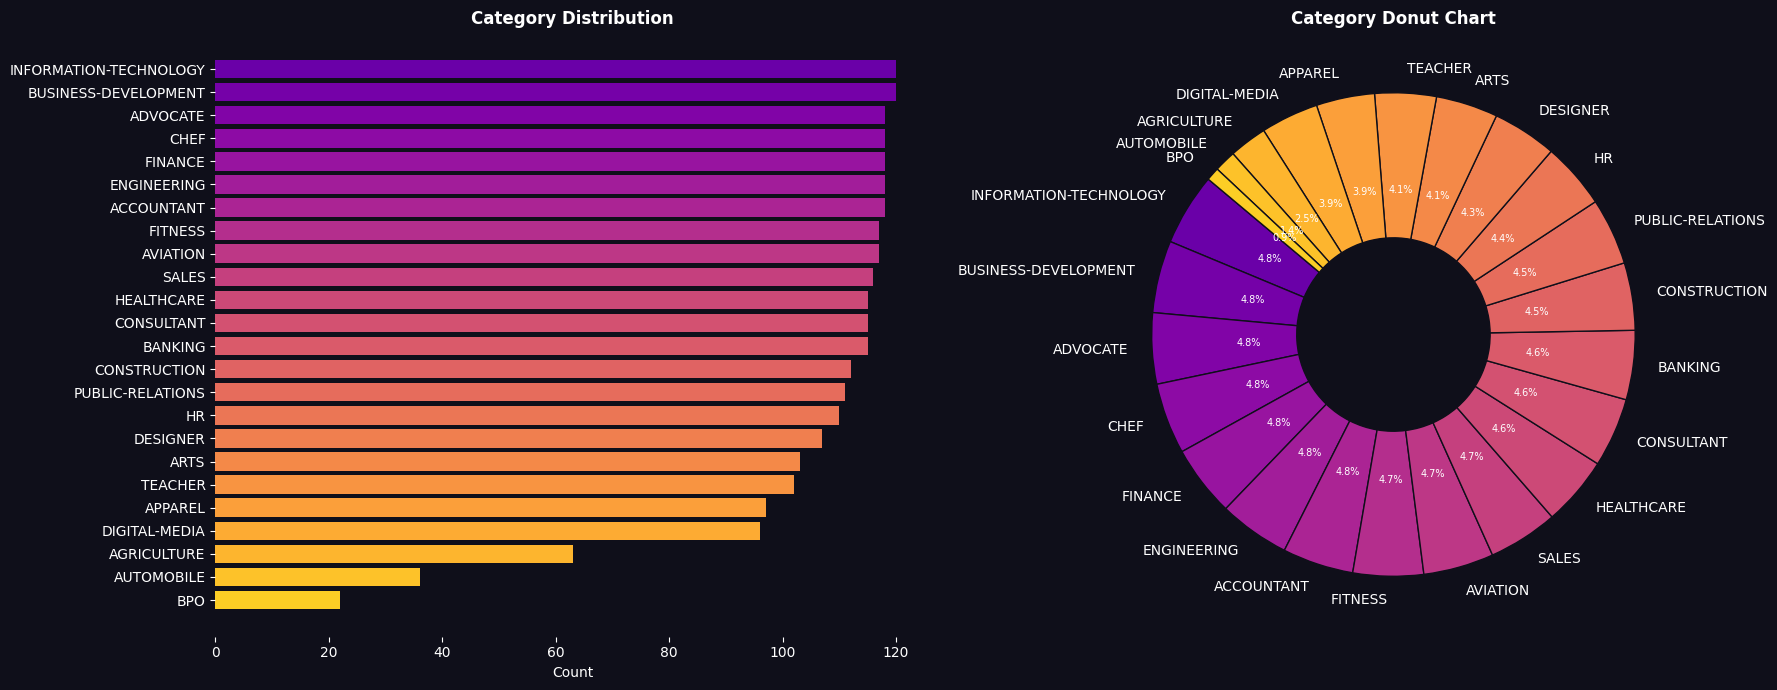

In [5]:
# ── Category distribution ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.patch.set_facecolor('#0f0f1a')

counts = df[CAT_COL].value_counts()
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(counts)))

# Bar chart
axes[0].set_facecolor('#0f0f1a')
axes[0].barh(counts.index, counts.values, color=colors, edgecolor='none')
axes[0].set_xlabel('Count', color='white')
axes[0].set_title('Category Distribution', color='white', fontweight='bold')
axes[0].tick_params(colors='white')
axes[0].invert_yaxis()
for sp in axes[0].spines.values(): sp.set_visible(False)

# Donut chart
axes[1].set_facecolor('#0f0f1a')
wedges, texts, autotexts = axes[1].pie(
    counts.values, labels=counts.index, autopct='%1.1f%%',
    colors=colors, startangle=140,
    wedgeprops=dict(width=0.6, edgecolor='#0f0f1a')
)
for t in texts: t.set_color('white')
for a in autotexts: a.set_color('white'); a.set_fontsize(7)
axes[1].set_title('Category Donut Chart', color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('../models/eda_categories.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

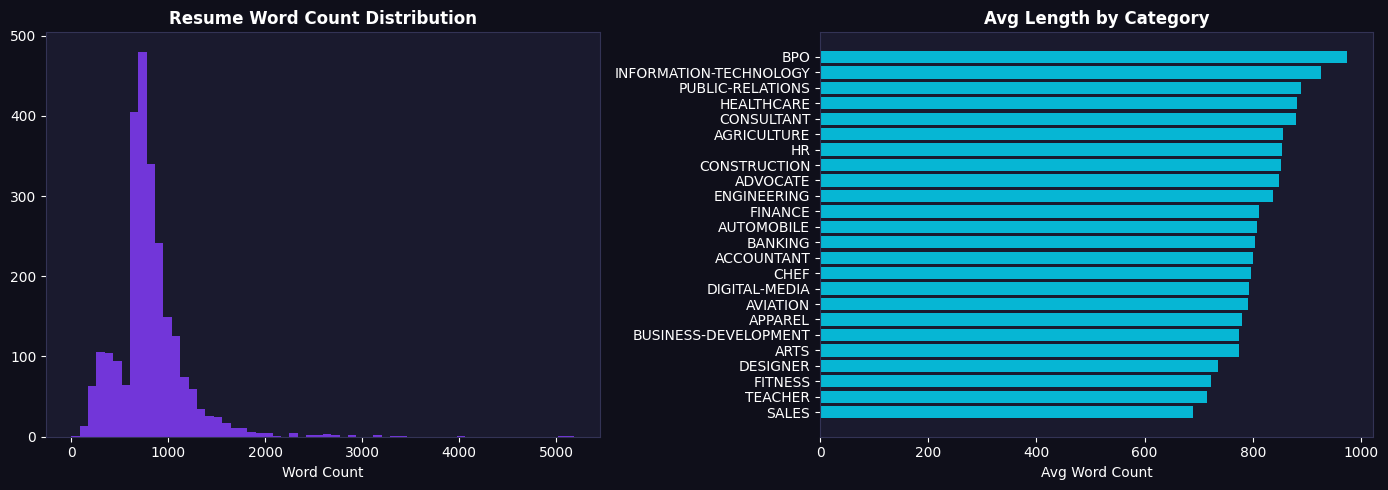

In [6]:
# ── Word count distribution ───────────────────────────────────────────────────
df['word_count'] = df[TEXT_COL].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0f0f1a')
for ax in axes:
    ax.set_facecolor('#1a1a2e')
    for sp in ax.spines.values(): sp.set_color('#333355')

axes[0].hist(df['word_count'], bins=60, color='#7c3aed', edgecolor='none', alpha=0.9)
axes[0].set_xlabel('Word Count', color='white')
axes[0].set_title('Resume Word Count Distribution', color='white', fontweight='bold')
axes[0].tick_params(colors='white')

avg = df.groupby(CAT_COL)['word_count'].mean().sort_values()
axes[1].barh(avg.index, avg.values, color='#06b6d4', edgecolor='none')
axes[1].set_xlabel('Avg Word Count', color='white')
axes[1].set_title('Avg Length by Category', color='white', fontweight='bold')
axes[1].tick_params(colors='white')

plt.tight_layout()
plt.savefig('../models/eda_lengths.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

## 5. Text Preprocessing

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def clean_resume(text: str) -> str:
    """
    Normalize resume text for TF-IDF:
    removes URLs, emails, phones, punctuation, digits,
    then lowercases, lemmatizes, and strips stopwords.
    """
    text = str(text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)                       # URLs
    text = re.sub(r'\S+@\S+', ' ', text)                                 # emails
    text = re.sub(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', ' ', text)  # phones
    text = re.sub(r'[^\w\s]', ' ', text)                                 # punctuation
    text = re.sub(r'\d+', ' ', text)                                      # digits
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    tokens = [
        lemmatizer.lemmatize(t)
        for t in text.split()
        if t not in stop_words and len(t) > 2
    ]
    return ' '.join(tokens)


print("Cleaning resumes ...")
df['clean_text'] = df[TEXT_COL].apply(clean_resume)
print(f"Done!  Sample:\n{df['clean_text'].iloc[0][:300]}")

Cleaning resumes ...
Done!  Sample:
administrator marketing associate administrator summary dedicated customer service manager year experience hospitality customer service management respected builder leader customer focused team strives instill shared enthusiastic commitment customer service highlight focused customer satisfaction te


## 6. Encode Labels & Train/Test Split

In [8]:
le = LabelEncoder()
df['label'] = le.fit_transform(df[CAT_COL])

X = df['clean_text']
y = df['label']

# Stratified split → balanced class proportions in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train : {len(X_train)} samples")
print(f"Test  : {len(X_test)} samples")
print(f"Classes ({len(le.classes_)}): {list(le.classes_)}")

Train : 1987 samples
Test  : 497 samples
Classes (24): ['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS', 'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT', 'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA', 'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR', 'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER']


Split ratio per class (should all be ~0.20 for 80/20 split):
label
ACCOUNTANT                0.203
ADVOCATE                  0.203
AGRICULTURE               0.206
APPAREL                   0.196
ARTS                      0.204
AUTOMOBILE                0.194
AVIATION                  0.205
BANKING                   0.200
BPO                       0.182
BUSINESS-DEVELOPMENT      0.200
CHEF                      0.203
CONSTRUCTION              0.196
CONSULTANT                0.200
DESIGNER                  0.196
DIGITAL-MEDIA             0.198
ENGINEERING               0.203
FINANCE                   0.203
FITNESS                   0.197
HEALTHCARE                0.200
HR                        0.200
INFORMATION-TECHNOLOGY    0.200
PUBLIC-RELATIONS          0.198
SALES                     0.198
TEACHER                   0.196


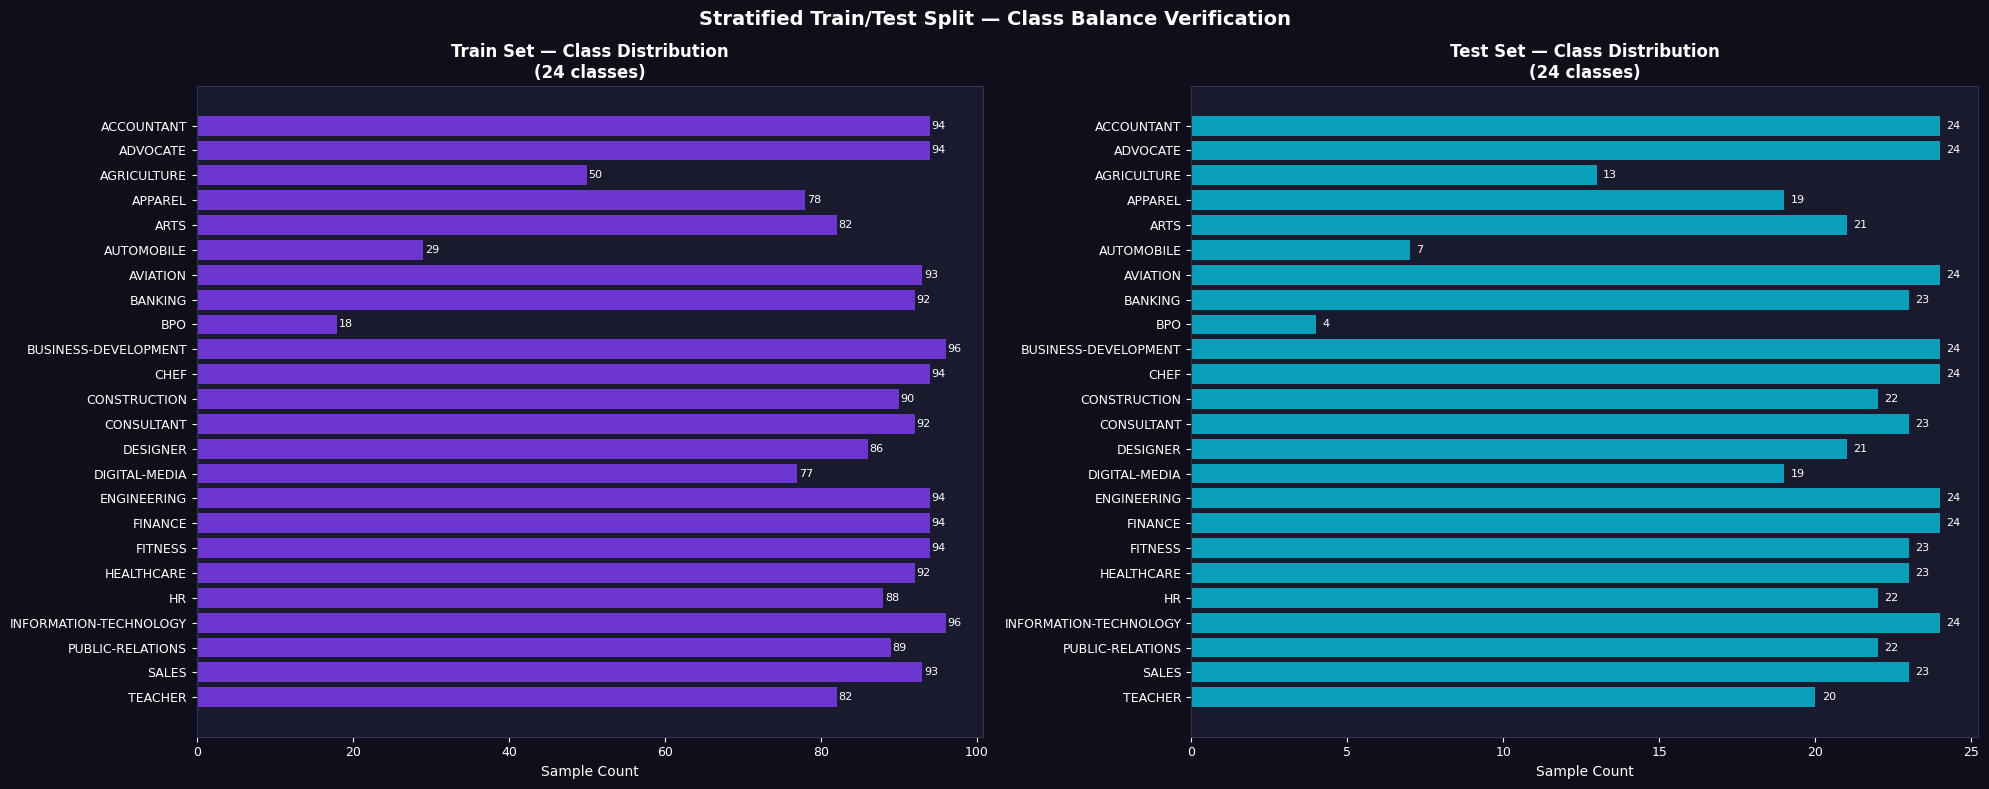


Saved: class_distribution_train_test.png


In [9]:
# ── Train vs Test Class Distribution — proves stratified split is balanced ─────
train_counts = pd.Series(y_train).map(
    dict(enumerate(le.classes_))).value_counts().sort_index()
test_counts  = pd.Series(y_test).map(
    dict(enumerate(le.classes_))).value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('#0f0f1a')

for ax, counts, split, color in zip(
    axes,
    [train_counts, test_counts],
    ['Train Set', 'Test Set'],
    ['#7c3aed', '#06b6d4']
):
    ax.set_facecolor('#1a1a2e')
    bars = ax.barh(counts.index, counts.values, color=color,
                   edgecolor='none', alpha=0.85)
    ax.set_xlabel('Sample Count', color='white')
    ax.set_title(f'{split} — Class Distribution\n({len(counts.index)} classes)',
                 color='white', fontweight='bold', fontsize=12)
    ax.tick_params(colors='white', labelsize=9)
    ax.invert_yaxis()
    for sp in ax.spines.values(): sp.set_color('#333355')
    for bar, val in zip(bars, counts.values):
        ax.text(val + 0.2, bar.get_y() + bar.get_height() / 2,
                str(val), va='center', color='white', fontsize=8)

# Overall balance check
total = train_counts + test_counts
balance_ratio = (test_counts / total).round(3)
print("Split ratio per class (should all be ~0.20 for 80/20 split):")
print(balance_ratio.to_string())

plt.suptitle('Stratified Train/Test Split — Class Balance Verification',
             color='white', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../models/class_distribution_train_test.png', dpi=120,
            bbox_inches='tight', facecolor='#0f0f1a')
plt.show()
print("\nSaved: class_distribution_train_test.png")

## 7. TF-IDF Vectorization

In [10]:
# Fit on train only to prevent data leakage
tfidf = TfidfVectorizer(
    max_features=15000,   # top 15k terms
    ngram_range=(1, 2),   # unigrams + bigrams
    sublinear_tf=True,    # log-scale TF dampening
    min_df=2,             # ignore very rare terms
    max_df=0.95,          # ignore near-universal terms
)

X_train_tf = tfidf.fit_transform(X_train)
X_test_tf  = tfidf.transform(X_test)

print(f"Train matrix : {X_train_tf.shape}")
print(f"Test matrix  : {X_test_tf.shape}")

Train matrix : (1987, 15000)
Test matrix  : (497, 15000)


## 7. Baseline ML Training — Default Parameters
> Train all models with sklearn defaults first. These scores are the **benchmark** we beat with tuning.

In [11]:
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    'Linear SVC'         : LinearSVC(C=1.0, max_iter=2000, random_state=42),
    'Random Forest'      : RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'Naive Bayes'        : MultinomialNB(alpha=1.0),
}
if ADVANCED:
    baseline_models['XGBoost']  = XGBClassifier(
        n_estimators=100, random_state=42, eval_metric='mlogloss', verbosity=0)
    baseline_models['LightGBM'] = LGBMClassifier(
        n_estimators=100, random_state=42, verbose=-1)

print("=" * 60)
print("  BASELINE RESULTS  (default parameters)")
print("=" * 60)

baseline_results = {}
for name, model in baseline_models.items():
    model.fit(X_train_tf, y_train)
    y_pred = model.predict(X_test_tf)
    baseline_results[name] = {
        'Accuracy'    : accuracy_score(y_test, y_pred),
        'F1-Macro'    : f1_score(y_test, y_pred, average='macro'),
        'F1-Weighted' : f1_score(y_test, y_pred, average='weighted'),
    }
    print(f"  {name:<22}  Acc={baseline_results[name]['Accuracy']:.4f}"
          f"  F1-W={baseline_results[name]['F1-Weighted']:.4f}")

baseline_df = pd.DataFrame(baseline_results).T.sort_values('F1-Weighted', ascending=False)

  BASELINE RESULTS  (default parameters)
  Logistic Regression     Acc=0.6459  F1-W=0.6224
  Linear SVC              Acc=0.7163  F1-W=0.7060
  Random Forest           Acc=0.7163  F1-W=0.6954
  Naive Bayes             Acc=0.5453  F1-W=0.4994
  XGBoost                 Acc=0.7827  F1-W=0.7773
  LightGBM                Acc=0.8270  F1-W=0.8208


## 8. Hyperparameter Tuning (Optimized)
> Reduced search spaces for fast runtime on Colab T4. Gradient Boosting and KNN excluded — consistently outperformed by LR/SVC/LightGBM on TF-IDF text.

In [20]:
tuned_models = {}
best_params  = {}

# ── 1. Logistic Regression ────────────────────────────────────────────────────
print("[1/5]  Tuning Logistic Regression ...")
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000),
    param_grid={'C': [0.1, 1, 10]},
    cv=2, scoring='f1_weighted', n_jobs=-1,
)
lr_grid.fit(X_train_tf, y_train)
tuned_models['Logistic Regression'] = lr_grid.best_estimator_
best_params['Logistic Regression']  = lr_grid.best_params_
print(f"  Best C  : {lr_grid.best_params_['C']}  |  CV F1-W : {lr_grid.best_score_:.4f}\n")

# ── 2. Linear SVC ─────────────────────────────────────────────────────────────
print("[2/5]  Tuning Linear SVC ...")
svc_grid = GridSearchCV(
    LinearSVC(random_state=42, max_iter=2000),
    param_grid={'C': [0.1, 1, 10]},
    cv=2, scoring='f1_weighted', n_jobs=-1,
)
svc_grid.fit(X_train_tf, y_train)
tuned_models['Linear SVC'] = svc_grid.best_estimator_
best_params['Linear SVC']  = svc_grid.best_params_
print(f"  Best C  : {svc_grid.best_params_['C']}  |  CV F1-W : {svc_grid.best_score_:.4f}\n")

# ── 3. Naive Bayes ────────────────────────────────────────────────────────────
print("[3/5]  Tuning Naive Bayes ...")
nb_grid = GridSearchCV(
    MultinomialNB(),
    param_grid={'alpha': [0.1, 0.5, 1.0]},
    cv=2, scoring='f1_weighted', n_jobs=-1,
)
nb_grid.fit(X_train_tf, y_train)
tuned_models['Naive Bayes'] = nb_grid.best_estimator_
best_params['Naive Bayes']  = nb_grid.best_params_
print(f"  Best alpha : {nb_grid.best_params_['alpha']}  |  CV F1-W : {nb_grid.best_score_:.4f}\n")

# ── 4. Random Forest — fixed params ──────────────────────────────────────────
print("[4/5]  Random Forest (fixed params) ...")
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    max_features='sqrt', random_state=42, n_jobs=-1
)
rf_model.fit(X_train_tf, y_train)
tuned_models['Random Forest'] = rf_model
best_params['Random Forest']  = {'n_estimators': 200, 'max_features': 'sqrt', 'note': 'fixed'}
y_pred_rf = rf_model.predict(X_test_tf)
print(f"  F1-W : {f1_score(y_test, y_pred_rf, average='weighted'):.4f}\n")

# ── 5. XGBoost + LightGBM ────────────────────────────────────────────────────
if ADVANCED:
    # XGBoost — fixed good defaults
    print("[5a]  XGBoost (fixed params) ...")
    xgb_model = XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, random_state=42, eval_metric='mlogloss', verbosity=0, n_jobs=-1
    )
    xgb_model.fit(X_train_tf, y_train)
    tuned_models['XGBoost'] = xgb_model
    best_params['XGBoost']  = {'n_estimators': 200, 'learning_rate': 0.1, 'note': 'fixed'}
    y_pred_xgb = xgb_model.predict(X_test_tf)
    print(f"  F1-W : {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}\n")

    # LightGBM — properly tuned (fastest to tune, usually wins)
    print("[5b]  Tuning LightGBM ...")
    lgb_rand = RandomizedSearchCV(
        LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        param_distributions={
            'n_estimators' : [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.2],
            'num_leaves'   : [31, 63, 127],
            'subsample'    : [0.8, 1.0],
        },
        n_iter=8, cv=2, scoring='f1_weighted', n_jobs=-1, random_state=42,
    )
    lgb_rand.fit(X_train_tf, y_train)
    tuned_models['LightGBM'] = lgb_rand.best_estimator_
    best_params['LightGBM']  = lgb_rand.best_params_
    print(f"  Best params : {lgb_rand.best_params_}  |  CV F1-W : {lgb_rand.best_score_:.4f}\n")

# ── Compile results ───────────────────────────────────────────────────────────
tuned_results = {}
for name, model in tuned_models.items():
    y_pred = model.predict(X_test_tf)
    tuned_results[name] = {
        'Accuracy'    : accuracy_score(y_test, y_pred),
        'F1-Macro'    : f1_score(y_test, y_pred, average='macro'),
        'F1-Weighted' : f1_score(y_test, y_pred, average='weighted'),
    }

results_df = pd.DataFrame(tuned_results).T.sort_values('F1-Weighted', ascending=False)
print("=" * 55)
print("  TUNED RESULTS")
print("=" * 55)
print(results_df.round(4))

[1/5]  Tuning Logistic Regression ...
  Best C  : 10  |  CV F1-W : 0.6316

[2/5]  Tuning Linear SVC ...
  Best C  : 10  |  CV F1-W : 0.6605

[3/5]  Tuning Naive Bayes ...
  Best alpha : 0.1  |  CV F1-W : 0.5296

[4/5]  Random Forest (fixed params) ...
  F1-W : 0.7295

[5a]  XGBoost (fixed params) ...
  F1-W : 0.7913

[5b]  Tuning LightGBM ...
  Best params : {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.1}  |  CV F1-W : 0.7282

  TUNED RESULTS
                     Accuracy  F1-Macro  F1-Weighted
LightGBM               0.8270    0.7756       0.8208
XGBoost                0.7968    0.7764       0.7913
Random Forest          0.7505    0.6790       0.7295
Linear SVC             0.7344    0.6988       0.7272
Logistic Regression    0.6841    0.6395       0.6743
Naive Bayes            0.5755    0.5053       0.5488


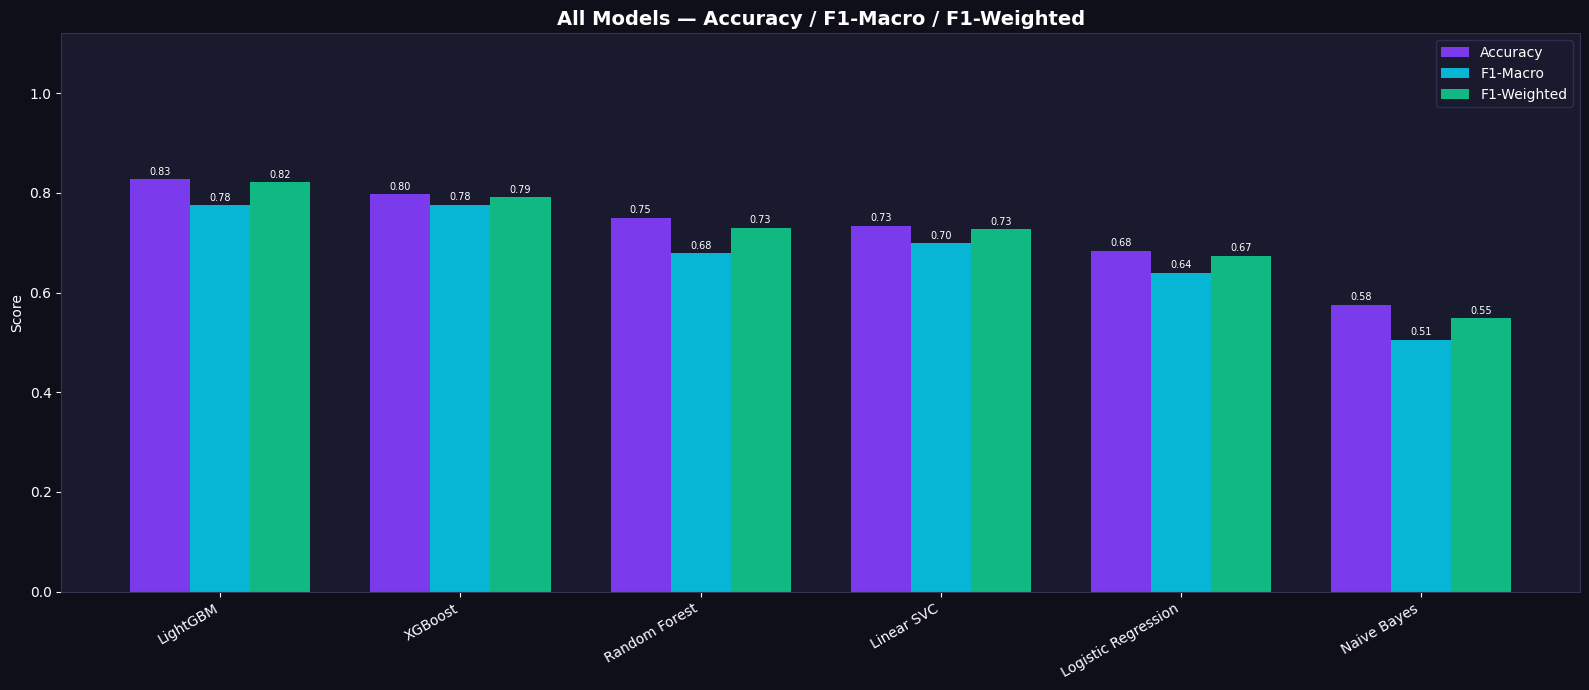

Saved: grouped_metrics_comparison.png


In [21]:
# ── Grouped Metrics: Accuracy / F1-Macro / F1-Weighted per model ─────────────
fig, ax = plt.subplots(figsize=(16, 7))
fig.patch.set_facecolor('#0f0f1a')
ax.set_facecolor('#1a1a2e')

metrics  = ['Accuracy', 'F1-Macro', 'F1-Weighted']
colors_3 = ['#7c3aed', '#06b6d4', '#10b981']
x = np.arange(len(results_df))
w = 0.25

for i, (metric, color) in enumerate(zip(metrics, colors_3)):
    bars = ax.bar(x + i * w, results_df[metric], w,
                  label=metric, color=color, edgecolor='none')
    # Value labels on top of each bar
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.005,
                f'{bar.get_height():.2f}',
                ha='center', va='bottom', color='white', fontsize=7)

ax.set_xticks(x + w)
ax.set_xticklabels(results_df.index, rotation=30, ha='right')
ax.set_ylabel('Score', color='white')
ax.set_ylim(0, 1.12)
ax.set_title('All Models — Accuracy / F1-Macro / F1-Weighted',
             color='white', fontweight='bold', fontsize=14)
ax.tick_params(colors='white')
ax.legend(facecolor='#1a1a2e', edgecolor='#333355', labelcolor='white')
for sp in ax.spines.values(): sp.set_color('#333355')

plt.tight_layout()
plt.savefig('../models/grouped_metrics_comparison.png', dpi=120,
            bbox_inches='tight', facecolor='#0f0f1a')
plt.show()
print("Saved: grouped_metrics_comparison.png")

## 9. ML Evaluation & Visualizations

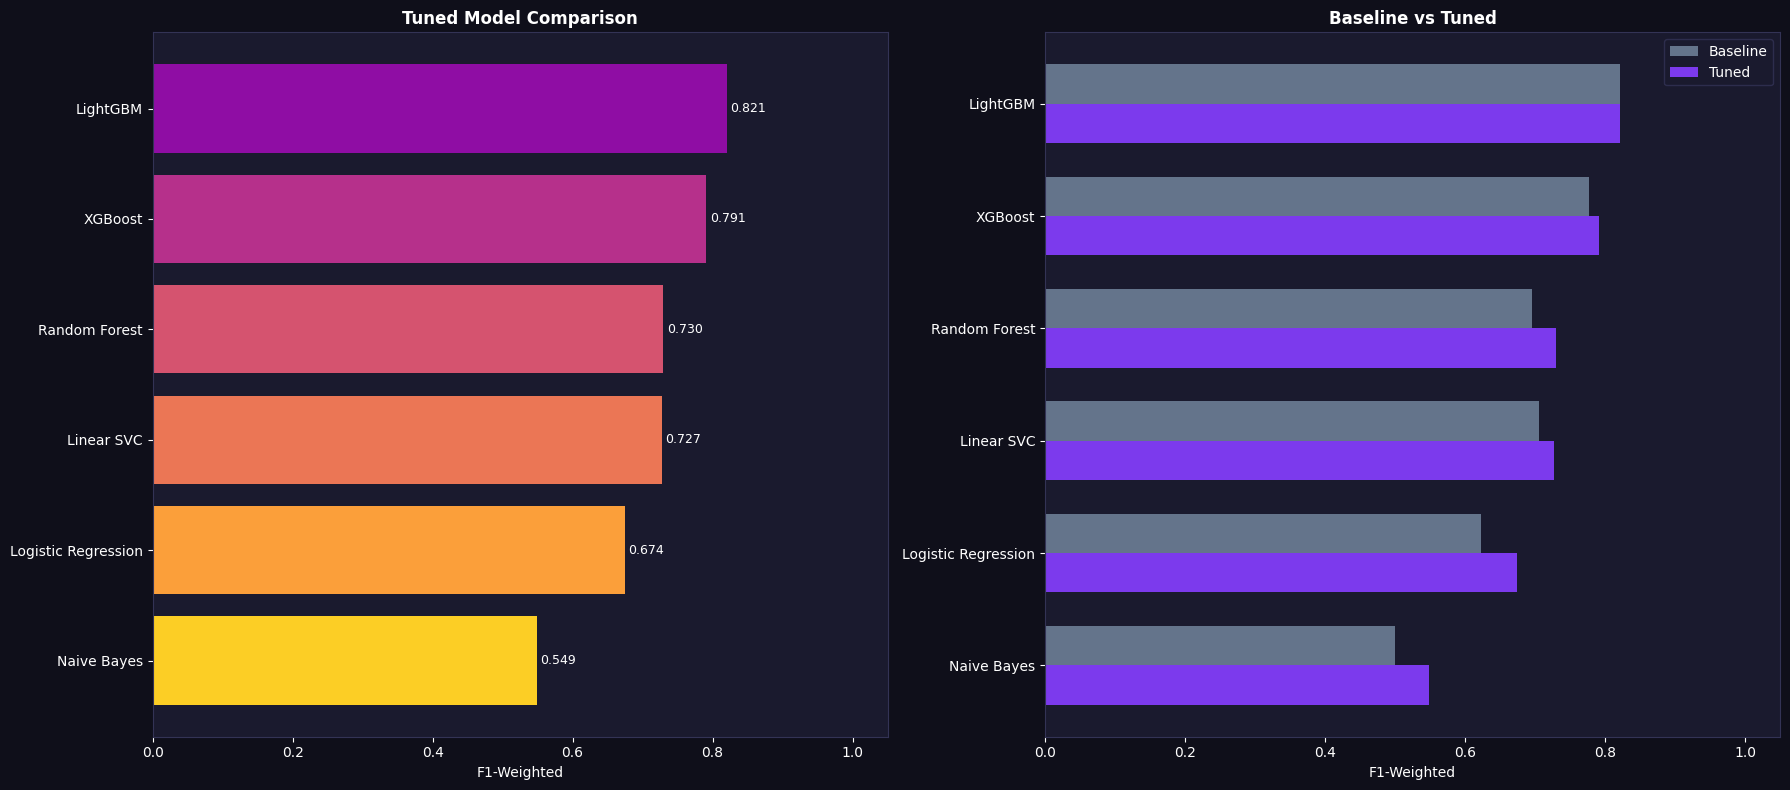

In [22]:
# ── Baseline vs Tuned comparison chart ───────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.patch.set_facecolor('#0f0f1a')

# Left: tuned F1-Weighted
ax = axes[0]
ax.set_facecolor('#1a1a2e')
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(results_df)))
bars = ax.barh(results_df.index, results_df['F1-Weighted'], color=colors, edgecolor='none')
ax.set_xlabel('F1-Weighted', color='white')
ax.set_title('Tuned Model Comparison', color='white', fontweight='bold')
ax.tick_params(colors='white')
for sp in ax.spines.values(): sp.set_color('#333355')
for bar, val in zip(bars, results_df['F1-Weighted']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height() / 2,
            f'{val:.3f}', va='center', color='white', fontsize=9)
ax.set_xlim(0, 1.05); ax.invert_yaxis()

# Right: baseline vs tuned
ax = axes[1]
ax.set_facecolor('#1a1a2e')
common = [m for m in results_df.index if m in baseline_df.index]
x = np.arange(len(common)); w = 0.35
ax.barh(x - w/2, [baseline_df.loc[m, 'F1-Weighted'] for m in common],
        w, label='Baseline', color='#64748b', edgecolor='none')
ax.barh(x + w/2, [results_df.loc[m, 'F1-Weighted'] for m in common],
        w, label='Tuned', color='#7c3aed', edgecolor='none')
ax.set_yticks(x); ax.set_yticklabels(common)
ax.set_xlabel('F1-Weighted', color='white')
ax.set_title('Baseline vs Tuned', color='white', fontweight='bold')
ax.tick_params(colors='white')
ax.legend(facecolor='#1a1a2e', edgecolor='#333355', labelcolor='white')
for sp in ax.spines.values(): sp.set_color('#333355')
ax.set_xlim(0, 1.05); ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

Best model : LightGBM
Accuracy   : 0.8270


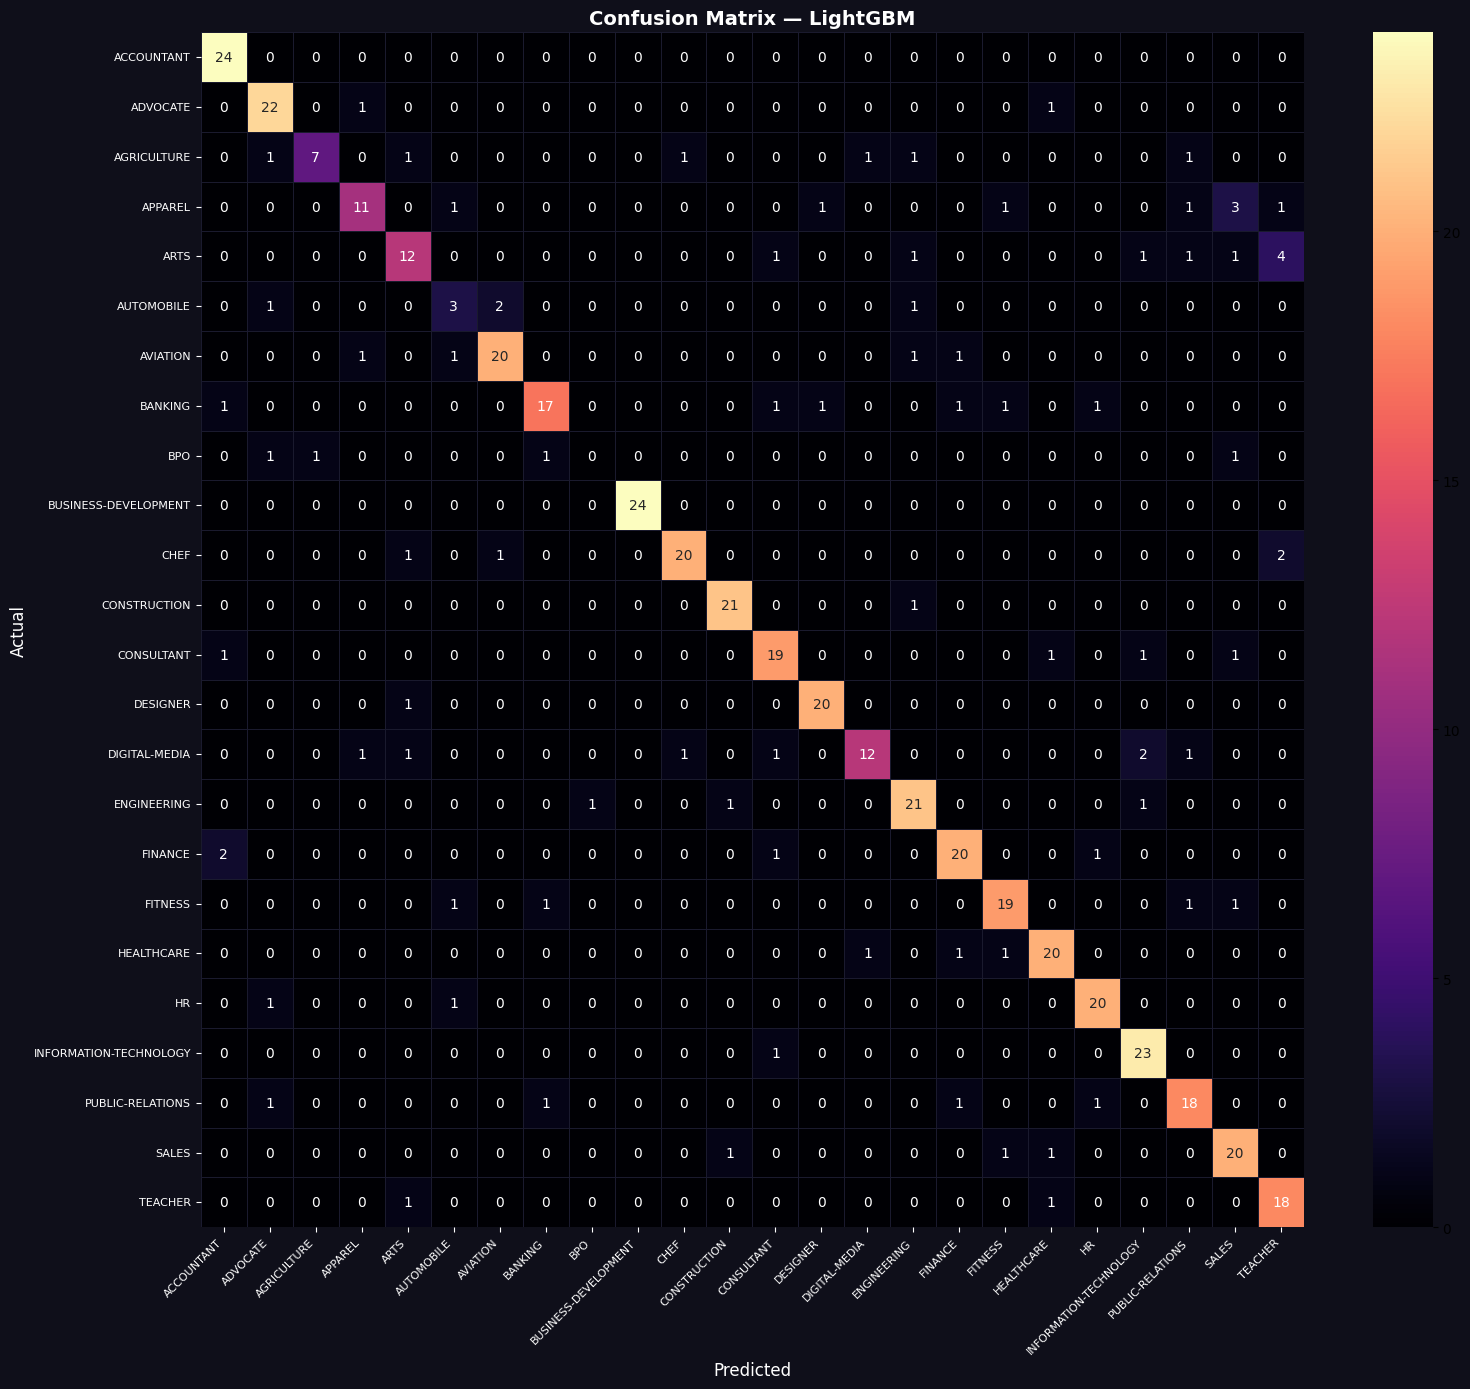


Classification Report — LightGBM:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.86      1.00      0.92        24
              ADVOCATE       0.81      0.92      0.86        24
           AGRICULTURE       0.88      0.54      0.67        13
               APPAREL       0.79      0.58      0.67        19
                  ARTS       0.71      0.57      0.63        21
            AUTOMOBILE       0.43      0.43      0.43         7
              AVIATION       0.87      0.83      0.85        24
               BANKING       0.85      0.74      0.79        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       1.00      1.00      1.00        24
                  CHEF       0.91      0.83      0.87        24
          CONSTRUCTION       0.91      0.95      0.93        22
            CONSULTANT       0.79      0.83      0.81        23
              DESIGNER       0.91      0.95      0.93        21
   

In [23]:
# ── Best model: confusion matrix + classification report ──────────────────────
best_name   = results_df.index[0]
best_model  = tuned_models[best_name]
y_pred_best = best_model.predict(X_test_tf)

print(f"Best model : {best_name}")
print(f"Accuracy   : {accuracy_score(y_test, y_pred_best):.4f}")

fig, ax = plt.subplots(figsize=(16, 14))
fig.patch.set_facecolor('#0f0f1a'); ax.set_facecolor('#0f0f1a')
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax,
            linewidths=0.5, linecolor='#1a1a2e')
ax.set_xlabel('Predicted', color='white', fontsize=12)
ax.set_ylabel('Actual',    color='white', fontsize=12)
ax.set_title(f'Confusion Matrix — {best_name}', color='white', fontweight='bold', fontsize=14)
ax.tick_params(colors='white', labelsize=8)
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

print(f"\nClassification Report — {best_name}:\n")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

Split ratio per class (should all be ~0.20 for 80/20 split):
label
ACCOUNTANT                0.203
ADVOCATE                  0.203
AGRICULTURE               0.206
APPAREL                   0.196
ARTS                      0.204
AUTOMOBILE                0.194
AVIATION                  0.205
BANKING                   0.200
BPO                       0.182
BUSINESS-DEVELOPMENT      0.200
CHEF                      0.203
CONSTRUCTION              0.196
CONSULTANT                0.200
DESIGNER                  0.196
DIGITAL-MEDIA             0.198
ENGINEERING               0.203
FINANCE                   0.203
FITNESS                   0.197
HEALTHCARE                0.200
HR                        0.200
INFORMATION-TECHNOLOGY    0.200
PUBLIC-RELATIONS          0.198
SALES                     0.198
TEACHER                   0.196


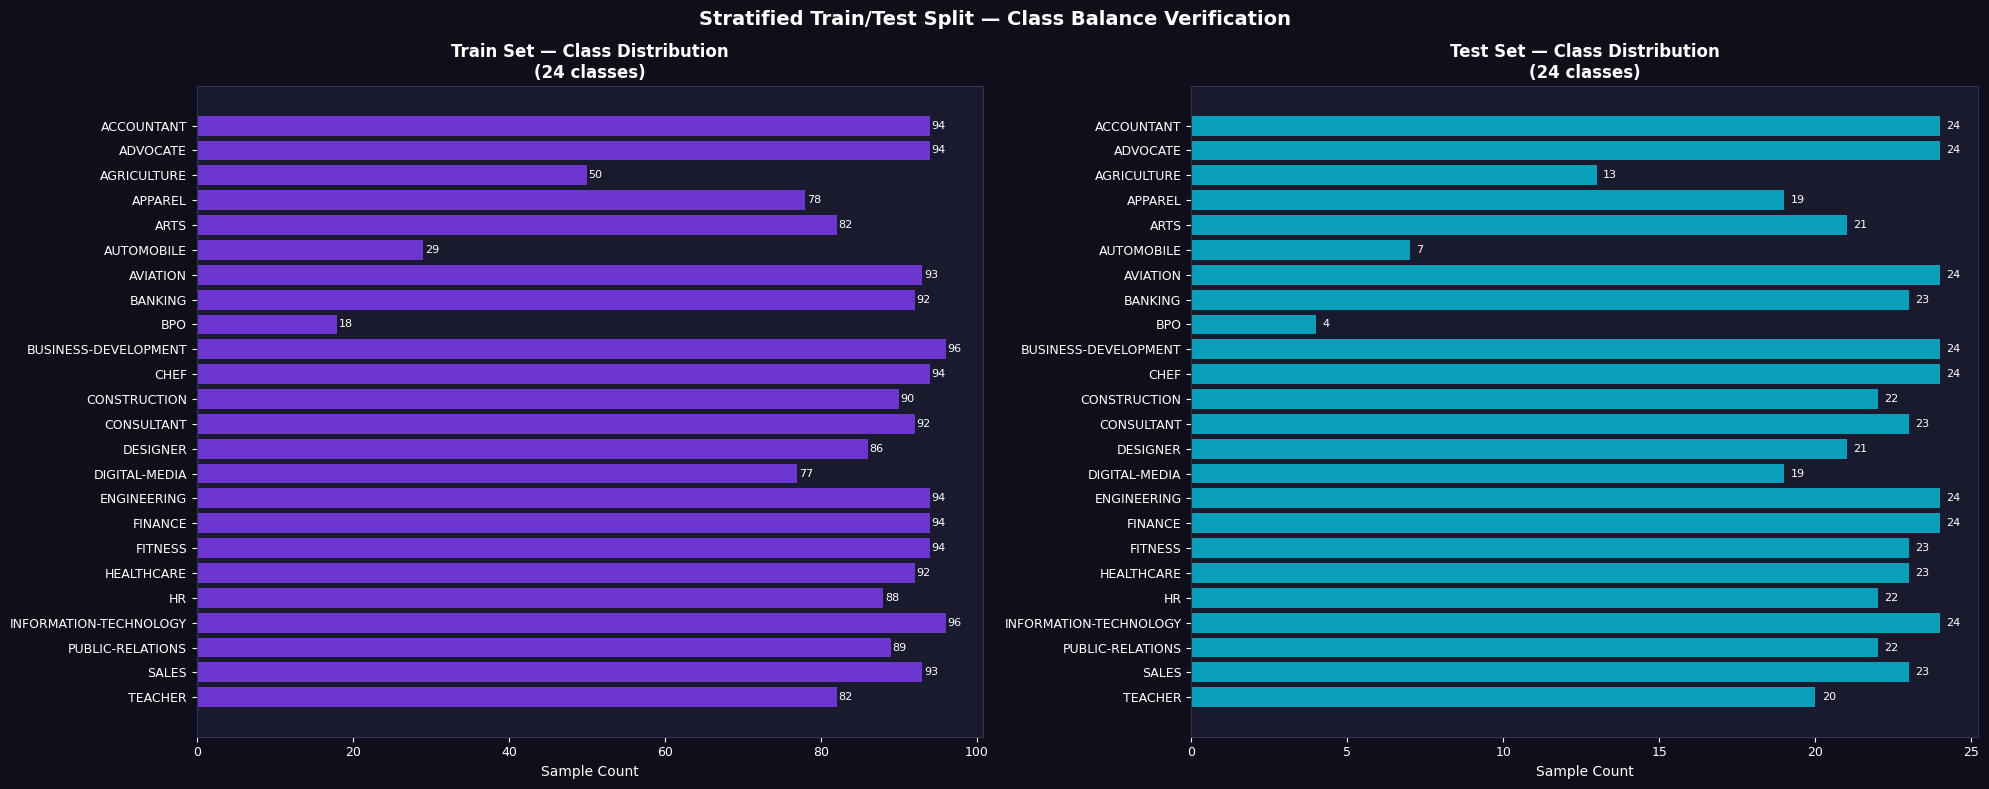


Saved: class_distribution_train_test.png


In [24]:
# ── Train vs Test Class Distribution — proves stratified split is balanced ─────
train_counts = pd.Series(y_train).map(
    dict(enumerate(le.classes_))).value_counts().sort_index()
test_counts  = pd.Series(y_test).map(
    dict(enumerate(le.classes_))).value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('#0f0f1a')

for ax, counts, split, color in zip(
    axes,
    [train_counts, test_counts],
    ['Train Set', 'Test Set'],
    ['#7c3aed', '#06b6d4']
):
    ax.set_facecolor('#1a1a2e')
    bars = ax.barh(counts.index, counts.values, color=color,
                   edgecolor='none', alpha=0.85)
    ax.set_xlabel('Sample Count', color='white')
    ax.set_title(f'{split} — Class Distribution\n({len(counts.index)} classes)',
                 color='white', fontweight='bold', fontsize=12)
    ax.tick_params(colors='white', labelsize=9)
    ax.invert_yaxis()
    for sp in ax.spines.values(): sp.set_color('#333355')
    for bar, val in zip(bars, counts.values):
        ax.text(val + 0.2, bar.get_y() + bar.get_height() / 2,
                str(val), va='center', color='white', fontsize=8)

# Overall balance check
total = train_counts + test_counts
balance_ratio = (test_counts / total).round(3)
print("Split ratio per class (should all be ~0.20 for 80/20 split):")
print(balance_ratio.to_string())

plt.suptitle('Stratified Train/Test Split — Class Balance Verification',
             color='white', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../models/class_distribution_train_test.png', dpi=120,
            bbox_inches='tight', facecolor='#0f0f1a')
plt.show()
print("\nSaved: class_distribution_train_test.png")

Running 5-fold CV on: LightGBM ...
CV Scores : [0.7807 0.7828 0.7642 0.7757 0.7798]
Mean ± Std: 0.7766 ± 0.0066


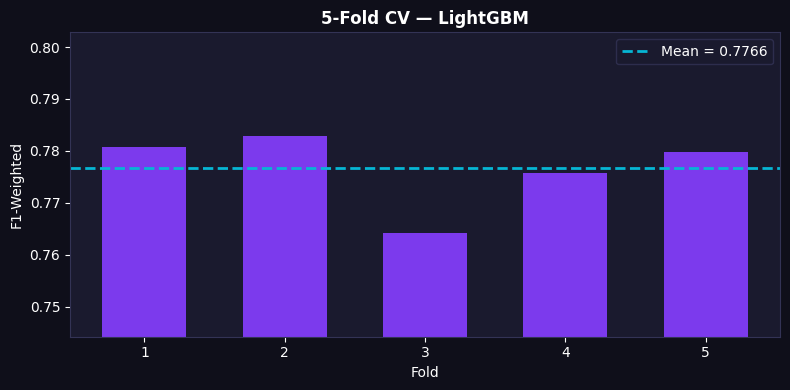

In [25]:
# ── 5-fold cross-validation on best model ─────────────────────────────────────
best_name  = results_df.index[0]
best_model = tuned_models[best_name]

print(f"Running 5-fold CV on: {best_name} ...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    clone(best_model), tfidf.transform(X), y,
    cv=cv, scoring='f1_weighted', n_jobs=-1
)
print(f"CV Scores : {cv_scores.round(4)}")
print(f"Mean ± Std: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

fig, ax = plt.subplots(figsize=(8, 4))
fig.patch.set_facecolor('#0f0f1a'); ax.set_facecolor('#1a1a2e')
ax.bar(range(1, 6), cv_scores, color='#7c3aed', edgecolor='none', width=0.6)
ax.axhline(cv_scores.mean(), color='#06b6d4', linestyle='--', linewidth=2,
           label=f'Mean = {cv_scores.mean():.4f}')
ax.set_xlabel('Fold', color='white'); ax.set_ylabel('F1-Weighted', color='white')
ax.set_title(f'5-Fold CV — {best_name}', color='white', fontweight='bold')
ax.tick_params(colors='white')
ax.legend(facecolor='#1a1a2e', edgecolor='#333355', labelcolor='white')
for sp in ax.spines.values(): sp.set_color('#333355')
ax.set_ylim(min(cv_scores) - 0.02, max(cv_scores) + 0.02)
plt.tight_layout()
plt.savefig('../models/cv_scores.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

In [26]:
print(f"Best model: {best_name}")
print(results_df[['Accuracy','F1-Weighted','F1-Macro']].sort_values('F1-Weighted', ascending=False))

Best model: LightGBM
                     Accuracy  F1-Weighted  F1-Macro
LightGBM             0.826962     0.820805  0.775582
XGBoost              0.796781     0.791299  0.776415
Random Forest        0.750503     0.729530  0.678983
Linear SVC           0.734406     0.727246  0.698760
Logistic Regression  0.684105     0.674322  0.639510
Naive Bayes          0.575453     0.548809  0.505340


## 10. Save ML Artifacts

In [27]:
import os, json, joblib
from pathlib import Path

# ── Saves directly to your project's models/ folder ──────────────────────────
MODELS_DIR = Path('./models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving to: {MODELS_DIR.resolve()}")

# ── Save ML artifacts ─────────────────────────────────────────────────────────
joblib.dump(best_model, MODELS_DIR / 'resume_model.pkl')
joblib.dump(tfidf,      MODELS_DIR / 'tfidf_vectorizer.pkl')
joblib.dump(le,         MODELS_DIR / 'label_encoder.pkl')
print("Saved: resume_model.pkl | tfidf_vectorizer.pkl | label_encoder.pkl")

# ── Save metadata ─────────────────────────────────────────────────────────────
def _safe(v):
    if v is None: return "None"
    try: json.dumps(v); return v
    except: return str(v)

meta = {
    'best_model_name' : best_name,
    'accuracy'        : float(results_df.loc[best_name, 'Accuracy']),
    'f1_weighted'     : float(results_df.loc[best_name, 'F1-Weighted']),
    'f1_macro'        : float(results_df.loc[best_name, 'F1-Macro']),
    'ner_model'       : 'yashpwr/resume-ner-bert-v2',
    'classes'         : list(le.classes_),
    'num_classes'     : int(len(le.classes_)),
    'tfidf_features'  : int(X_train_tf.shape[1]),
    'train_samples'   : int(len(X_train)),
    'test_samples'    : int(len(X_test)),
    'cv_mean'         : float(cv_scores.mean()),
    'cv_std'          : float(cv_scores.std()),
    'all_results'     : results_df.round(4).to_dict(),
    'best_hyperparams': {m: {k: _safe(v) for k, v in p.items()}
                         for m, p in best_params.items()},
}

with open(MODELS_DIR / 'model_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)
print("Saved: model_meta.json")

# ── Verify ────────────────────────────────────────────────────────────────────
print(f"\n✅ All artifacts saved to: {MODELS_DIR.resolve()}")
for fname in sorted(os.listdir(MODELS_DIR)):
    fpath = MODELS_DIR / fname
    if fpath.is_file():
        print(f"  {fname:<40} {fpath.stat().st_size / 1024:.1f} KB")

Saving to: C:\Users\SANYAM\Downloads\ai-resume-analyzer\ai-resume-analyzer\notebooks\models
Saved: resume_model.pkl | tfidf_vectorizer.pkl | label_encoder.pkl
Saved: model_meta.json

✅ All artifacts saved to: C:\Users\SANYAM\Downloads\ai-resume-analyzer\ai-resume-analyzer\notebooks\models
  label_encoder.pkl                        0.7 KB
  model_meta.json                          2.0 KB
  resume_model.pkl                         6788.7 KB
  tfidf_vectorizer.pkl                     619.4 KB


---
# Section B — NER: Entity Extraction
> Using **`yashpwr/resume-ner-bert-v2`** — pre-trained on 22,542 resumes, 90.87% F1.
> No training needed. Extracts: Name, Email, Phone, Skills, Companies, Degree, College, Location, and more.

## 11. Load Pre-trained NER Model

In [ ]:
# Load directly from HuggingFace Hub — no training required
NER_MODEL = "yashpwr/resume-ner-bert-v2"

ner_pipeline = hf_pipeline(
    "token-classification",
    model=NER_MODEL,
    aggregation_strategy="simple",   # merges B-/I- tokens into full entities
    device=0,                       # CPU; change to 0 for GPU
)

print(f"NER model loaded: {NER_MODEL}")
print("Entity types it can extract:")
entity_types = [
    "Name", "Email Address", "Phone", "Location",
    "Skills", "Designation", "Companies worked at", "Years of Experience",
    "Degree", "College Name", "Graduation Year"
]
for e in entity_types:
    print(f"  • {e}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

NER model loaded: yashpwr/resume-ner-bert-v2
Entity types it can extract:
  • Name
  • Email Address
  • Phone
  • Location
  • Skills
  • Designation
  • Companies worked at
  • Years of Experience
  • Degree
  • College Name
  • Graduation Year


## 12. NER — Entity Extraction on Test Samples + Frequency Charts

In [ ]:
# ── Run NER on a sample of 50 test resumes ────────────────────────────────────
sample_indices = X_test.sample(50, random_state=42).index
sample_texts   = df.loc[sample_indices, TEXT_COL].tolist()   # raw text for NER

print("Running NER on 50 sample resumes ...")
all_entities = []

for i, text in enumerate(sample_texts):
    # Truncate to 512 tokens worth of characters (NER model limit)
    results = ner_pipeline(text[:2000])
    for ent in results:
        all_entities.append({
            'resume_idx'  : i,
            'entity_type' : ent['entity_group'],
            'text'        : ent['word'],
            'confidence'  : round(ent['score'], 3),
        })

ner_df = pd.DataFrame(all_entities)
print(f"Total entities extracted : {len(ner_df)}")
print(f"Unique entity types      : {ner_df['entity_type'].nunique()}")
print("\nEntity type counts:")
print(ner_df['entity_type'].value_counts())

Running NER on 50 sample resumes ...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Total entities extracted : 1402
Unique entity types      : 4

Entity type counts:
entity_type
Degree                 606
Companies worked at    477
Skills                 318
Designation              1
Name: count, dtype: int64


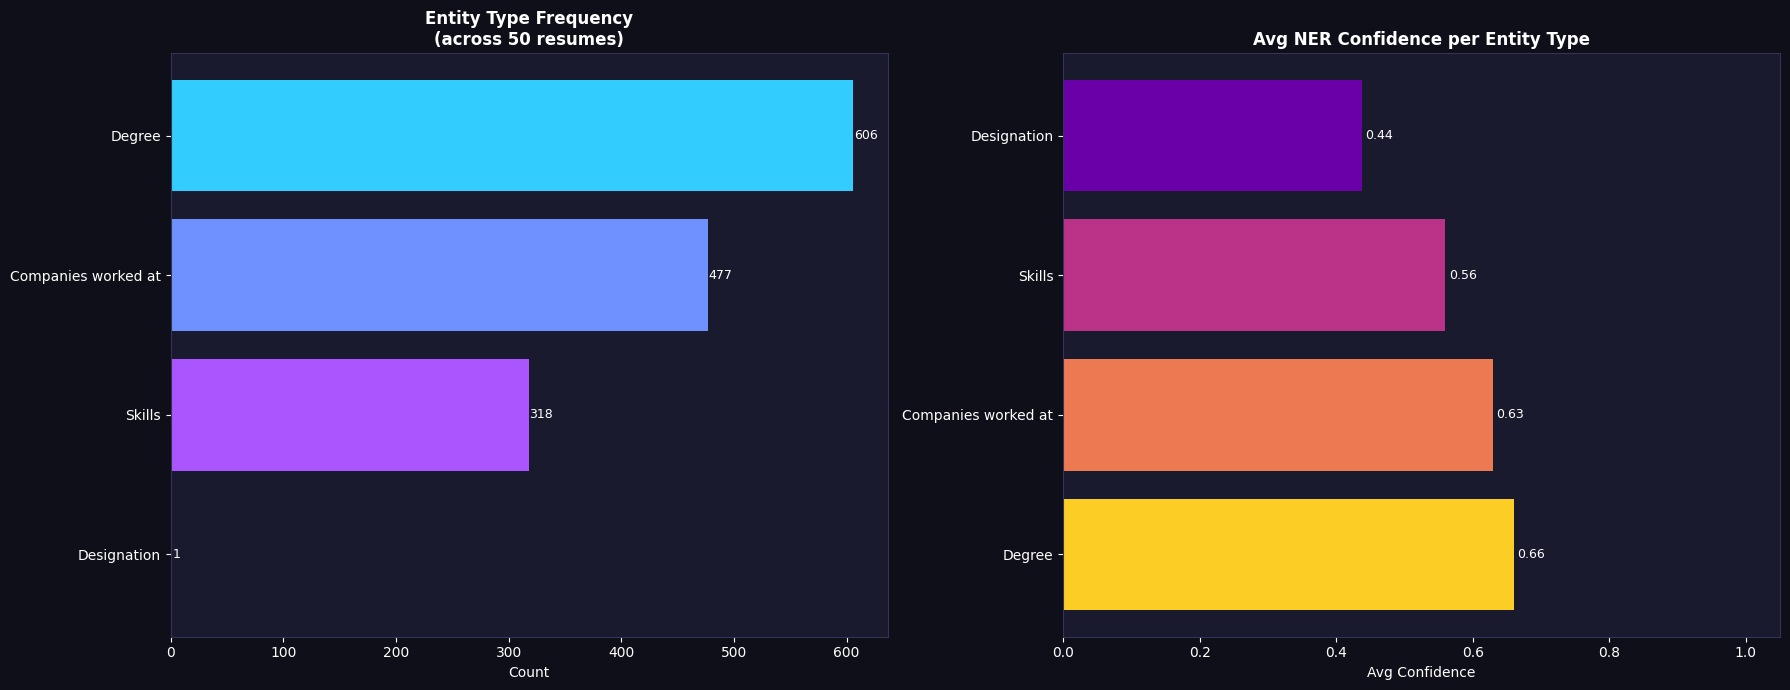

In [ ]:
# ── Entity frequency bar chart ────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.patch.set_facecolor('#0f0f1a')

# Left: entity type frequency
ax = axes[0]
ax.set_facecolor('#1a1a2e')
type_counts = ner_df['entity_type'].value_counts()
colors = plt.cm.cool(np.linspace(0.2, 0.9, len(type_counts)))
bars = ax.barh(type_counts.index, type_counts.values, color=colors, edgecolor='none')
ax.set_xlabel('Count', color='white')
ax.set_title('Entity Type Frequency\n(across 50 resumes)', color='white', fontweight='bold')
ax.tick_params(colors='white')
for sp in ax.spines.values(): sp.set_color('#333355')
for bar, val in zip(bars, type_counts.values):
    ax.text(val + 0.3, bar.get_y() + bar.get_height() / 2,
            str(val), va='center', color='white', fontsize=9)
ax.invert_yaxis()

# Right: avg confidence per entity type
ax = axes[1]
ax.set_facecolor('#1a1a2e')
avg_conf = ner_df.groupby('entity_type')['confidence'].mean().sort_values()
colors2  = plt.cm.plasma(np.linspace(0.2, 0.9, len(avg_conf)))
bars2 = ax.barh(avg_conf.index, avg_conf.values, color=colors2, edgecolor='none')
ax.set_xlabel('Avg Confidence', color='white')
ax.set_title('Avg NER Confidence per Entity Type', color='white', fontweight='bold')
ax.tick_params(colors='white')
ax.set_xlim(0, 1.05)
for sp in ax.spines.values(): sp.set_color('#333355')
for bar, val in zip(bars2, avg_conf.values):
    ax.text(val + 0.005, bar.get_y() + bar.get_height() / 2,
            f'{val:.2f}', va='center', color='white', fontsize=9)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../models/ner_entity_frequency.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

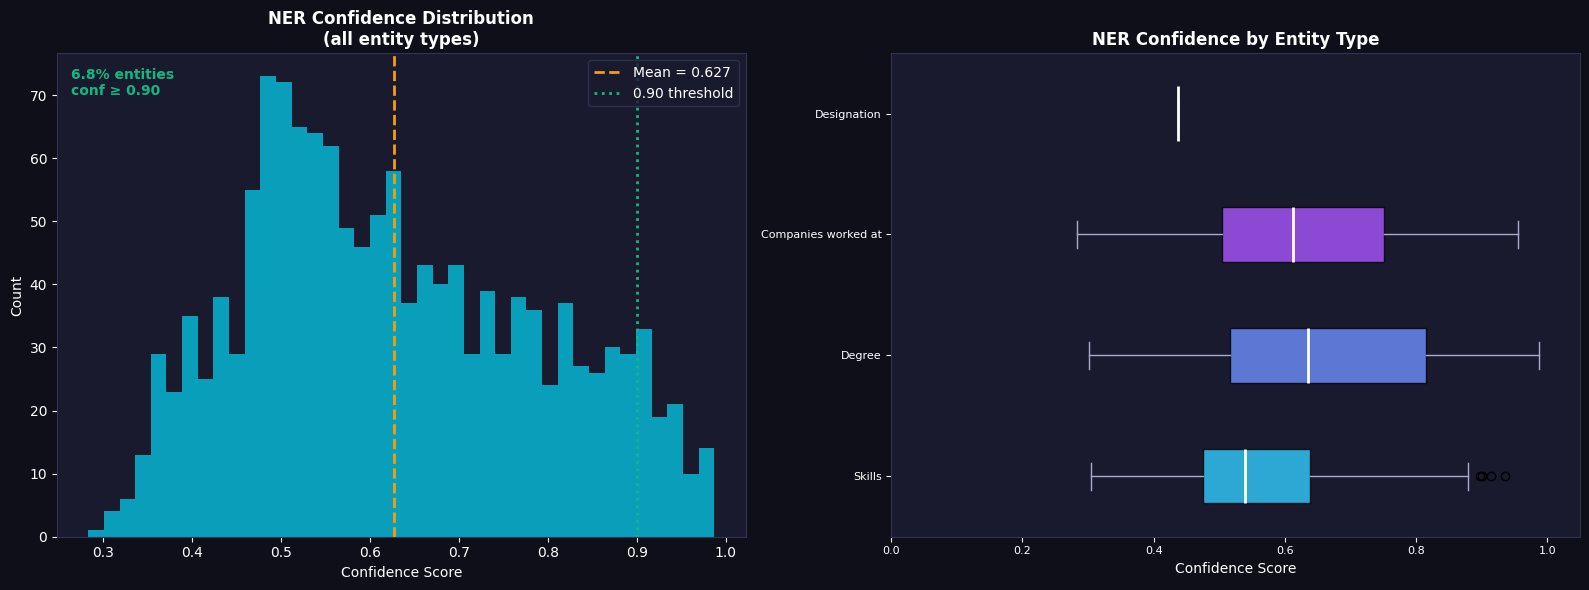

NER Confidence Summary:
                      mean    min    max  count
entity_type                                    
Degree               0.660  0.301  0.987    606
Companies worked at  0.630  0.283  0.956    477
Skills               0.560  0.305  0.936    318
Designation          0.437  0.437  0.437      1

Saved: ner_confidence_distribution.png


In [ ]:
# ── NER Confidence Score Distribution ────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#0f0f1a')

# Left: overall confidence histogram
ax = axes[0]
ax.set_facecolor('#1a1a2e')
ax.hist(ner_df['confidence'], bins=40, color='#06b6d4',
        edgecolor='none', alpha=0.85)
ax.axvline(ner_df['confidence'].mean(), color='#f59e0b',
           linestyle='--', linewidth=2,
           label=f"Mean = {ner_df['confidence'].mean():.3f}")
ax.axvline(0.90, color='#10b981', linestyle=':', linewidth=2,
           label='0.90 threshold')
ax.set_xlabel('Confidence Score', color='white')
ax.set_ylabel('Count', color='white')
ax.set_title('NER Confidence Distribution\n(all entity types)',
             color='white', fontweight='bold', fontsize=12)
ax.tick_params(colors='white')
ax.legend(facecolor='#1a1a2e', edgecolor='#333355', labelcolor='white')
for sp in ax.spines.values(): sp.set_color('#333355')

# Stats annotation
high_conf = (ner_df['confidence'] >= 0.90).mean() * 100
ax.text(0.02, 0.97, f'{high_conf:.1f}% entities\nconf ≥ 0.90',
        transform=ax.transAxes, color='#10b981',
        fontsize=10, va='top', fontweight='bold')

# Right: box plot per entity type
ax = axes[1]
ax.set_facecolor('#1a1a2e')

entity_types  = ner_df['entity_type'].unique()
conf_per_type = [ner_df[ner_df['entity_type'] == e]['confidence'].values
                 for e in entity_types]

bp = ax.boxplot(conf_per_type, vert=False, patch_artist=True,
                medianprops=dict(color='white', linewidth=2))

colors_box = plt.cm.cool(np.linspace(0.2, 0.9, len(entity_types)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
for element in ['whiskers', 'caps', 'fliers']:
    for item in bp[element]:
        item.set_color('#aaaacc')

ax.set_yticks(range(1, len(entity_types) + 1))
ax.set_yticklabels(entity_types, fontsize=8)
ax.set_xlabel('Confidence Score', color='white')
ax.set_title('NER Confidence by Entity Type',
             color='white', fontweight='bold', fontsize=12)
ax.tick_params(colors='white', labelsize=8)
ax.set_xlim(0, 1.05)
for sp in ax.spines.values(): sp.set_color('#333355')

plt.tight_layout()
plt.savefig('../models/ner_confidence_distribution.png', dpi=120,
            bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

# Summary stats
print("NER Confidence Summary:")
print(ner_df.groupby('entity_type')['confidence']
      .agg(['mean', 'min', 'max', 'count'])
      .round(3)
      .sort_values('mean', ascending=False)
      .to_string())
print(f"\nSaved: ner_confidence_distribution.png")

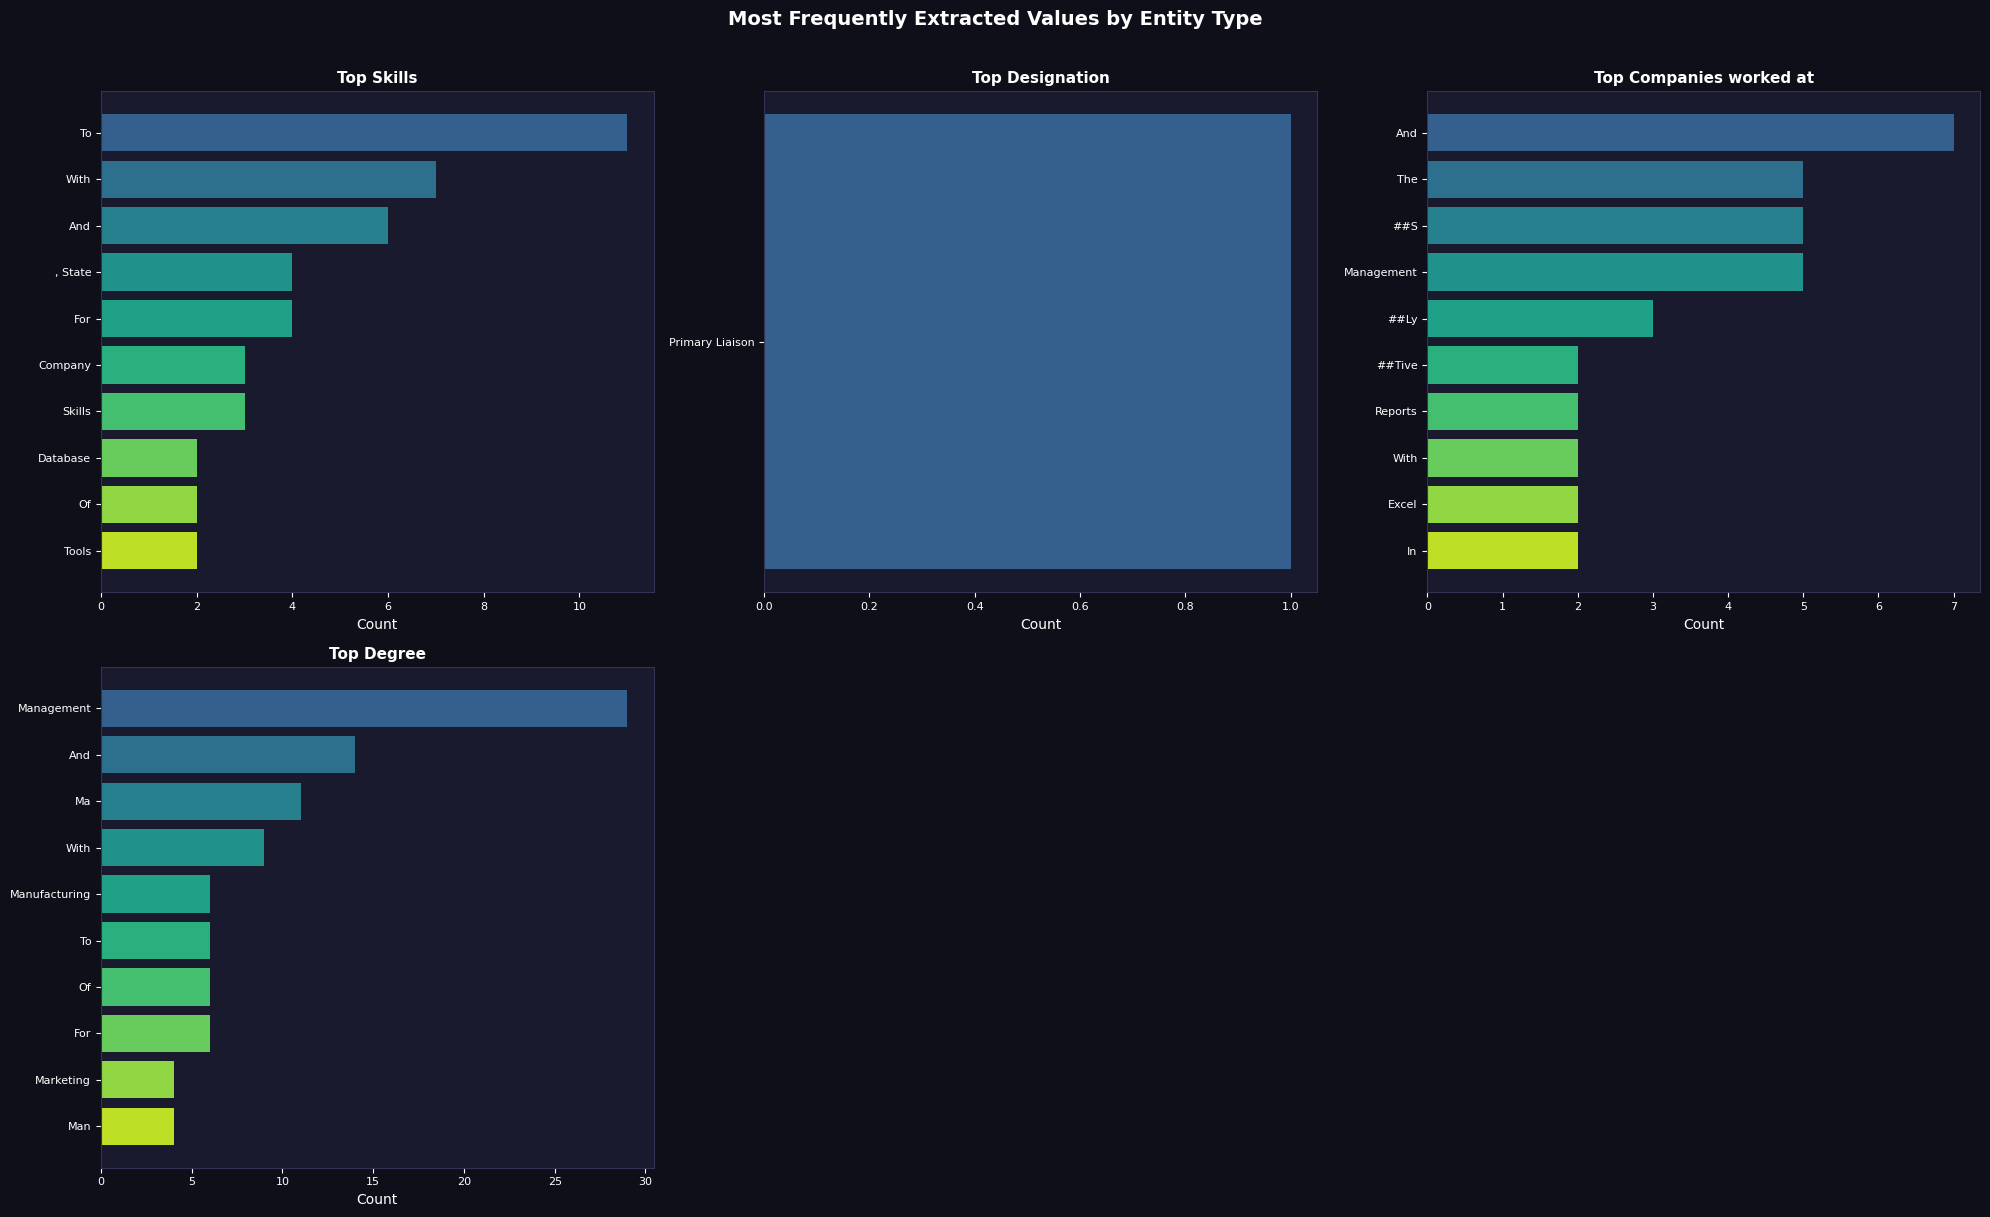

In [ ]:
# ── Top extracted values per entity type ─────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.patch.set_facecolor('#0f0f1a')
axes = axes.flatten()

# Pick the 6 most interesting entity types
top_types = ['Skills', 'Designation', 'Companies worked at',
             'Degree', 'Location', 'College Name']
top_types = [t for t in top_types if t in ner_df['entity_type'].unique()]

for i, etype in enumerate(top_types[:6]):
    ax = axes[i]
    ax.set_facecolor('#1a1a2e')
    subset = ner_df[ner_df['entity_type'] == etype]['text']
    # Clean and count
    top_vals = Counter(
        v.strip().title() for v in subset if len(v.strip()) > 1
    ).most_common(10)

    if not top_vals:
        ax.set_visible(False)
        continue

    labels, vals = zip(*top_vals)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(vals)))
    ax.barh(labels, vals, color=colors, edgecolor='none')
    ax.set_title(f'Top {etype}', color='white', fontweight='bold', fontsize=11)
    ax.tick_params(colors='white', labelsize=8)
    ax.set_xlabel('Count', color='white')
    ax.invert_yaxis()
    for sp in ax.spines.values(): sp.set_color('#333355')

# Hide unused subplots
for j in range(len(top_types), 6):
    axes[j].set_visible(False)

plt.suptitle('Most Frequently Extracted Values by Entity Type',
             color='white', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../models/ner_top_values.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

---
# Section C — Combined Pipeline Demo
> Feed **3 resumes from different domains** through both models simultaneously.
> This is exactly what your app does in production.

## 13. Combined Pipeline — 3 Resume Demo

In [ ]:
# ── Load saved ML artifacts ───────────────────────────────────────────────────
ml_model = joblib.load('../models/resume_model.pkl')
ml_tfidf = joblib.load('../models/tfidf_vectorizer.pkl')
ml_le    = joblib.load('../models/label_encoder.pkl')


def predict_domain(raw_text: str) -> dict:
    """Run ML domain classifier on a single resume."""
    cleaned = clean_resume(raw_text)
    vec     = ml_tfidf.transform([cleaned])
    pred_id = ml_model.predict(vec)[0]
    domain  = ml_le.classes_[pred_id]

    # Probability scores (not available for LinearSVC)
    try:
        proba = ml_model.predict_proba(vec)[0]
        top3  = [
            {'domain': ml_le.classes_[i], 'confidence': round(float(proba[i]), 3)}
            for i in np.argsort(proba)[::-1][:3]
        ]
    except AttributeError:
        top3 = [{'domain': domain, 'confidence': 1.0}]

    return {'predicted_domain': domain, 'top3': top3}


def extract_entities(raw_text: str) -> dict:
    """Run NER model on a single resume."""
    results = ner_pipeline(raw_text[:2000])
    entities = {}
    for ent in results:
        etype = ent['entity_group']
        if etype not in entities:
            entities[etype] = []
        entities[etype].append({
            'value'     : ent['word'],
            'confidence': round(ent['score'], 3),
        })
    return entities


# ── Pick 3 resumes from 3 different domains ───────────────────────────────────
target_domains = ['DATA SCIENCE', 'HR', 'INFORMATION-TECHNOLOGY']
# Fall back gracefully if a domain doesn't exist in the dataset
available = df[CAT_COL].str.upper().unique()
target_domains = [d for d in target_domains if d in available]
if len(target_domains) < 3:
    target_domains = list(df[CAT_COL].unique())[:3]

demo_resumes = []
for domain in target_domains:
    row = df[df[CAT_COL].str.upper() == domain].sample(1, random_state=42).iloc[0]
    demo_resumes.append({
        'true_domain': row[CAT_COL],
        'raw_text'   : row[TEXT_COL],
    })

print(f"Demo resumes selected from domains: {[r['true_domain'] for r in demo_resumes]}")

Demo resumes selected from domains: ['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY']


In [ ]:
# ── Run both pipelines on each resume ─────────────────────────────────────────
demo_results = []

for i, resume in enumerate(demo_resumes):
    print(f"\n{'='*65}")
    print(f"  RESUME {i+1}  |  True Domain: {resume['true_domain']}")
    print(f"{'='*65}")

    # ML Classification
    ml_result  = predict_domain(resume['raw_text'])
    # NER Extraction
    ner_result = extract_entities(resume['raw_text'])

    print(f"\n  [ML CLASSIFIER]")
    print(f"  Predicted Domain : {ml_result['predicted_domain']}")
    print(f"  Top 3 Predictions:")
    for t in ml_result['top3']:
        print(f"    {t['domain']:<30} {t['confidence']*100:.1f}%")

    print(f"\n  [NER EXTRACTOR]")
    for etype, ents in ner_result.items():
        values = ', '.join([e['value'] for e in ents[:3]])   # show up to 3 per type
        print(f"  {etype:<28} {values}")

    demo_results.append({
        'true_domain'     : resume['true_domain'],
        'ml_prediction'   : ml_result['predicted_domain'],
        'ml_correct'      : ml_result['predicted_domain'].upper() == resume['true_domain'].upper(),
        'ml_top3'         : ml_result['top3'],
        'ner_entities'    : ner_result,
        'entity_count'    : sum(len(v) for v in ner_result.values()),
    })

print(f"\n{'='*65}")
print("  Pipeline complete for all 3 resumes!")


  RESUME 1  |  True Domain: HR

  [ML CLASSIFIER]
  Predicted Domain : HR
  Top 3 Predictions:
    HR                             100.0%

  [NER EXTRACTOR]
  Companies worked at          a challenging position, which utilizes my skills, hard work and provides opportunities, POL, ##MERS PVT. LTD at its manufacturing unit and assisted HRM & SAP at the unit. Possess strong communication
  Degree                       of rich, Management, Training & Development
  Skills                       , Organization Developement, Time, ,, , Performance

  RESUME 2  |  True Domain: DESIGNER

  [ML CLASSIFIER]
  Predicted Domain : DESIGNER
  Top 3 Predictions:
    DESIGNER                       100.0%

  [NER EXTRACTOR]
  Companies worked at          over 30 years of experience in print, logo design, and dimensional signs. Passionate about comprehensive,, large home builders, such as Stanley Martin, Ryan Homes, NV Homes, Van Metre Homes, Stylecraft Homes, Dan Ryan Homes etc. Adhered, client review De

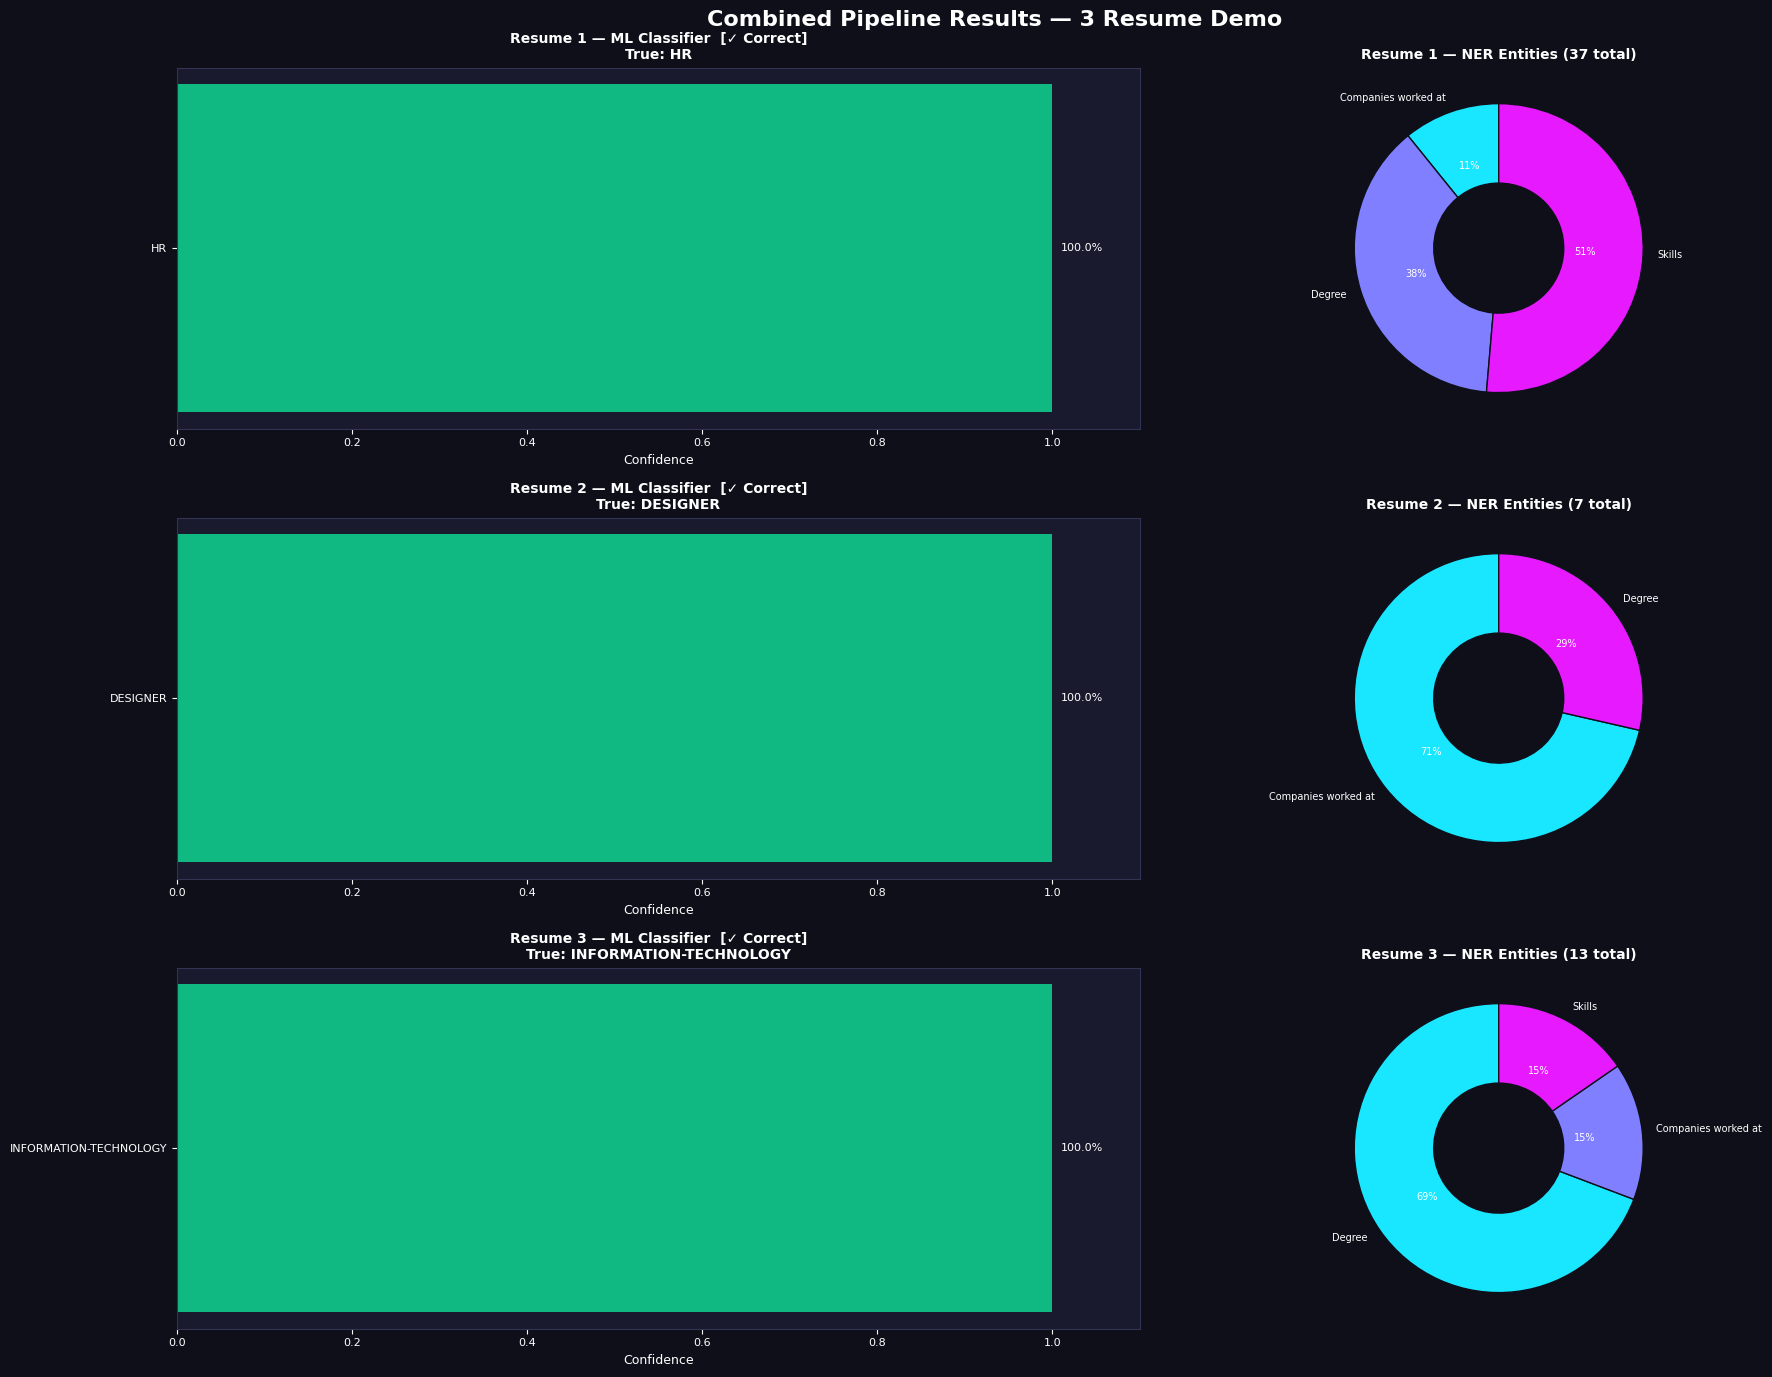

In [ ]:
# ── Visualization: combined pipeline results ──────────────────────────────────
fig = plt.figure(figsize=(20, 14))
fig.patch.set_facecolor('#0f0f1a')
fig.suptitle('Combined Pipeline Results — 3 Resume Demo',
             color='white', fontweight='bold', fontsize=16, y=0.98)

for i, result in enumerate(demo_results):
    # ── Left column: ML domain confidence bar ──────────────────────────────
    ax_ml = fig.add_subplot(3, 2, i * 2 + 1)
    ax_ml.set_facecolor('#1a1a2e')

    top3    = result['ml_top3']
    domains = [t['domain'] for t in top3]
    confs   = [t['confidence'] for t in top3]
    bar_cols = ['#10b981' if d.upper() == result['true_domain'].upper()
                else '#7c3aed' for d in domains]
    ax_ml.barh(domains, confs, color=bar_cols, edgecolor='none')
    ax_ml.set_xlim(0, 1.1)
    ax_ml.set_xlabel('Confidence', color='white', fontsize=9)
    correct_label = '✓ Correct' if result['ml_correct'] else '✗ Wrong'
    ax_ml.set_title(
        f"Resume {i+1} — ML Classifier  [{correct_label}]\nTrue: {result['true_domain']}",
        color='white', fontweight='bold', fontsize=10
    )
    ax_ml.tick_params(colors='white', labelsize=8)
    for sp in ax_ml.spines.values(): sp.set_color('#333355')
    for bar, val in zip(ax_ml.patches, confs):
        ax_ml.text(val + 0.01, bar.get_y() + bar.get_height() / 2,
                   f'{val*100:.1f}%', va='center', color='white', fontsize=8)
    ax_ml.invert_yaxis()

    # ── Right column: NER entity count donut ───────────────────────────────
    ax_ner = fig.add_subplot(3, 2, i * 2 + 2)
    ax_ner.set_facecolor('#0f0f1a')

    ner     = result['ner_entities']
    etypes  = list(ner.keys())
    ecounts = [len(v) for v in ner.values()]

    if etypes:
        colors_ner = plt.cm.cool(np.linspace(0.1, 0.9, len(etypes)))
        wedges, texts, autotexts = ax_ner.pie(
            ecounts, labels=etypes, autopct='%1.0f%%',
            colors=colors_ner, startangle=90,
            wedgeprops=dict(width=0.55, edgecolor='#0f0f1a'),
        )
        for t in texts: t.set_color('white'); t.set_fontsize(7)
        for a in autotexts: a.set_color('white'); a.set_fontsize(7)
    else:
        ax_ner.text(0.5, 0.5, 'No entities found',
                    ha='center', va='center', color='white')

    ax_ner.set_title(
        f"Resume {i+1} — NER Entities ({result['entity_count']} total)",
        color='white', fontweight='bold', fontsize=10
    )

plt.tight_layout()
plt.savefig('../models/combined_pipeline_demo.png', dpi=120, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

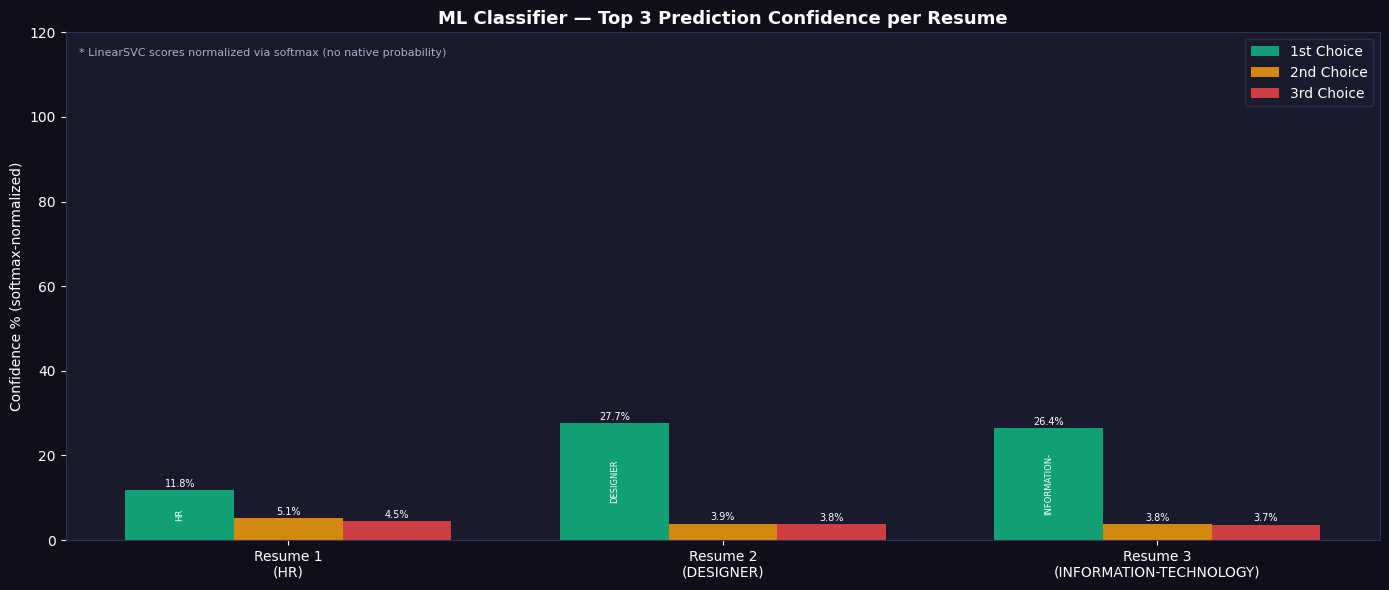


Top 3 Predictions per Resume:

  Resume 1 (True: HR)
    1. ✓ HR                             11.8%
    2.   CONSULTANT                     5.1%
    3.   ADVOCATE                       4.5%

  Resume 2 (True: DESIGNER)
    1. ✓ DESIGNER                       27.7%
    2.   SALES                          3.9%
    3.   BUSINESS-DEVELOPMENT           3.8%

  Resume 3 (True: INFORMATION-TECHNOLOGY)
    1. ✓ INFORMATION-TECHNOLOGY         26.4%
    2.   HR                             3.8%
    3.   BUSINESS-DEVELOPMENT           3.7%

Saved: demo_ml_confidence_comparison.png


In [ ]:
# ── C2: ML Confidence Comparison — works for both LinearSVC and LR ────────────
from sklearn.preprocessing import MinMaxScaler

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('#0f0f1a')
ax.set_facecolor('#1a1a2e')

x      = np.arange(3)
width  = 0.25
labels = [f"Resume {i+1}\n({r['true_domain']})" for i, r in enumerate(demo_results)]

# Re-run predictions with proper score extraction
demo_top3_fixed = []

for resume in demo_resumes:
    cleaned = clean_resume(resume['raw_text'])
    vec     = ml_tfidf.transform([cleaned])

    if hasattr(ml_model, 'predict_proba'):
        # Logistic Regression → use probabilities directly
        scores  = ml_model.predict_proba(vec)[0]
    elif hasattr(ml_model, 'decision_function'):
        # LinearSVC → use decision function, normalize to 0-1
        raw     = ml_model.decision_function(vec)[0]
        # Softmax normalization so scores sum to 1 and are comparable
        e_x     = np.exp(raw - np.max(raw))
        scores  = e_x / e_x.sum()
    else:
        scores = np.ones(len(ml_le.classes_)) / len(ml_le.classes_)

    top3_idx = np.argsort(scores)[::-1][:3]
    top3 = [
        {'domain': ml_le.classes_[i], 'confidence': float(scores[i])}
        for i in top3_idx
    ]
    demo_top3_fixed.append(top3)

# Plot
choice_labels  = ['1st Choice', '2nd Choice', '3rd Choice']
choice_colors  = ['#10b981',    '#f59e0b',    '#ef4444']

for i, (label, color) in enumerate(zip(choice_labels, choice_colors)):
    confs = []
    names = []
    for j, top3 in enumerate(demo_top3_fixed):
        try:
            confs.append(top3[i]['confidence'] * 100)
            names.append(top3[i]['domain'])
        except IndexError:
            confs.append(0)
            names.append('')

    bars = ax.bar(x + i * width, confs, width, label=label,
                  color=color, edgecolor='none', alpha=0.85)

    for bar, val, name in zip(bars, confs, names):
        if val > 1:
            # Confidence % on top
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.8,
                    f'{val:.1f}%',
                    ha='center', color='white', fontsize=7)
            # Domain name inside bar if tall enough
            if val > 10:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        bar.get_height() / 2,
                        name[:12],
                        ha='center', va='center',
                        color='white', fontsize=6, rotation=90)

ax.set_xticks(x + width)
ax.set_xticklabels(labels, color='white', fontsize=10)
ax.set_ylabel('Confidence % (softmax-normalized)', color='white')
ax.set_ylim(0, 120)
ax.set_title('ML Classifier — Top 3 Prediction Confidence per Resume',
             color='white', fontweight='bold', fontsize=13)
ax.tick_params(colors='white')
ax.legend(facecolor='#1a1a2e', edgecolor='#333355', labelcolor='white')
for sp in ax.spines.values(): sp.set_color('#333355')

# Note explaining normalization
ax.text(0.01, 0.97,
        '* LinearSVC scores normalized via softmax (no native probability)',
        transform=ax.transAxes, color='#aaaacc', fontsize=8, va='top')

plt.tight_layout()
plt.savefig('../models/demo_ml_confidence_comparison.png', dpi=120,
            bbox_inches='tight', facecolor='#0f0f1a')
plt.show()

# Print top 3 for each resume
print("\nTop 3 Predictions per Resume:")
for i, (top3, resume) in enumerate(zip(demo_top3_fixed, demo_resumes)):
    print(f"\n  Resume {i+1} (True: {resume['true_domain']})")
    for rank, t in enumerate(top3, 1):
        marker = '✓' if t['domain'].upper() == resume['true_domain'].upper() else ' '
        print(f"    {rank}. {marker} {t['domain']:<30} {t['confidence']*100:.1f}%")

print("\nSaved: demo_ml_confidence_comparison.png")

In [ ]:
# ── Summary table ─────────────────────────────────────────────────────────────
summary = pd.DataFrame([{
    'Resume'          : f"Resume {i+1}",
    'True Domain'     : r['true_domain'],
    'ML Predicted'    : r['ml_prediction'],
    'ML Correct'      : '✓' if r['ml_correct'] else '✗',
    'Entities Found'  : r['entity_count'],
    'Entity Types'    : len(r['ner_entities']),
} for i, r in enumerate(demo_results)])

print("\nCombined Pipeline Summary")
print("=" * 75)
print(summary.to_string(index=False))
print("=" * 75)
print(f"\nML Accuracy on demo : {sum(r['ml_correct'] for r in demo_results)}/3")
print(f"Avg entities/resume : {np.mean([r['entity_count'] for r in demo_results]):.1f}")


Combined Pipeline Summary
  Resume            True Domain           ML Predicted ML Correct  Entities Found  Entity Types
Resume 1                     HR                     HR          ✓              37             3
Resume 2               DESIGNER               DESIGNER          ✓               7             2
Resume 3 INFORMATION-TECHNOLOGY INFORMATION-TECHNOLOGY          ✓              13             3

ML Accuracy on demo : 3/3
Avg entities/resume : 19.0


  PIPELINE TIMING BENCHMARK
  ML Preprocessing + Predict          6.1 ms
  NER Inference (BERT)                55.2 ms
  Combined Pipeline                   44.6 ms


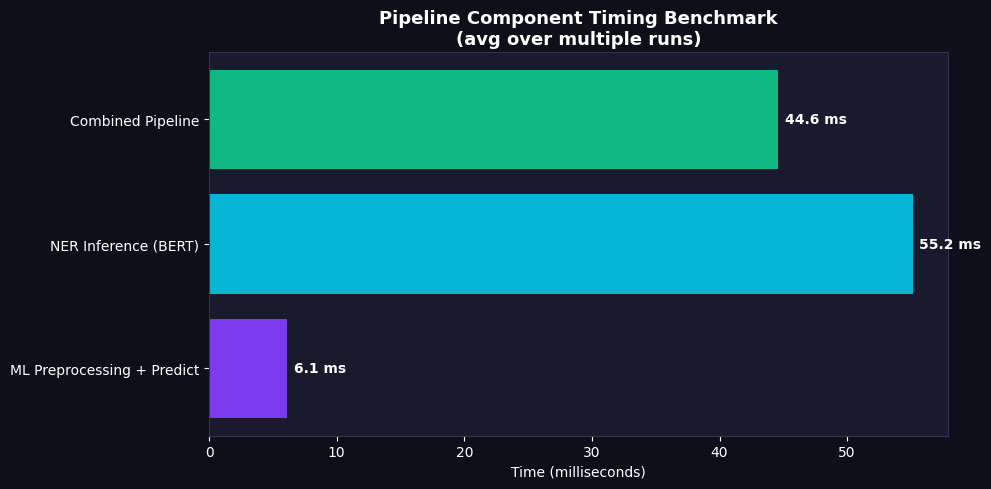

Saved: pipeline_timing.png

  MODEL CARD — AI Resume Analyzer

COMPONENT 1: Domain Classifier
  Model Type    : Linear SVC
  Task          : Multi-class text classification
  Classes       : 24 resume domains
  Features      : TF-IDF (max 15,000 features, unigrams + bigrams)
  Accuracy      : 0.7324
  F1-Weighted   : 0.7256
  F1-Macro      : 0.6972
  CV Mean F1    : 0.7019 ± 0.0065
  Train samples : 1987
  Test samples  : 497
  Best Params   : {'C': 10}

COMPONENT 2: NER Extractor
  Model         : yashpwr/resume-ner-bert-v2
  Base          : BERT (bert-base-cased)
  Task          : Token classification (Named Entity Recognition)
  Entity Types  : 25 (Name, Skills, Companies, Degree, etc.)
  F1 Score      : 90.87% (reported by model authors)
  Training Data : 22,542 resume samples
  Source        : HuggingFace Hub (pre-trained, no fine-tuning needed)

DATASET
  Source        : Kaggle — snehaanbhawal/resume-dataset
  Total samples : 2484
  Classes       : 24
  Train/Test    : 80% / 20% 

In [ ]:
# =============================================================================
# FINAL CELL 1 — Pipeline Timing Benchmark
# Shows how fast each component runs — good for report's performance section
# =============================================================================
import time

print("=" * 55)
print("  PIPELINE TIMING BENCHMARK")
print("=" * 55)

sample_text = demo_resumes[0]['raw_text']
timings = {}

# ML preprocessing + prediction
t0 = time.time()
for _ in range(10):   # average over 10 runs
    cleaned  = clean_resume(sample_text)
    vec      = ml_tfidf.transform([cleaned])
    ml_model.predict(vec)
timings['ML Preprocessing + Predict'] = (time.time() - t0) / 10 * 1000  # ms

# NER inference
t0 = time.time()
for _ in range(5):
    ner_pipeline(sample_text[:2000])
timings['NER Inference (BERT)'] = (time.time() - t0) / 5 * 1000  # ms

# Combined pipeline
t0 = time.time()
for _ in range(5):
    cleaned = clean_resume(sample_text)
    vec     = ml_tfidf.transform([cleaned])
    ml_model.predict(vec)
    ner_pipeline(sample_text[:2000])
timings['Combined Pipeline'] = (time.time() - t0) / 5 * 1000  # ms

# Print results
for name, ms in timings.items():
    print(f"  {name:<35} {ms:.1f} ms")
print("=" * 55)

# ── Timing bar chart ──────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#0f0f1a')
ax.set_facecolor('#1a1a2e')

names  = list(timings.keys())
values = list(timings.values())
colors = ['#7c3aed', '#06b6d4', '#10b981']

bars = ax.barh(names, values, color=colors, edgecolor='none')
ax.set_xlabel('Time (milliseconds)', color='white')
ax.set_title('Pipeline Component Timing Benchmark\n(avg over multiple runs)',
             color='white', fontweight='bold', fontsize=13)
ax.tick_params(colors='white')
for sp in ax.spines.values(): sp.set_color('#333355')
for bar, val in zip(bars, values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height() / 2,
            f'{val:.1f} ms', va='center', color='white', fontsize=10,
            fontweight='bold')

plt.tight_layout()
plt.savefig('../models/pipeline_timing.png', dpi=120,
            bbox_inches='tight', facecolor='#0f0f1a')
plt.show()
print("Saved: pipeline_timing.png")


# =============================================================================
# FINAL CELL 2 — Model Card Summary (text output for report)
# Clean printout of everything about both models — paste into report directly
# =============================================================================
print("\n" + "=" * 65)
print("  MODEL CARD — AI Resume Analyzer")
print("=" * 65)

print(f"""
COMPONENT 1: Domain Classifier
  Model Type    : {best_name}
  Task          : Multi-class text classification
  Classes       : {len(le.classes_)} resume domains
  Features      : TF-IDF (max 15,000 features, unigrams + bigrams)
  Accuracy      : {float(results_df.loc[best_name, 'Accuracy']):.4f}
  F1-Weighted   : {float(results_df.loc[best_name, 'F1-Weighted']):.4f}
  F1-Macro      : {float(results_df.loc[best_name, 'F1-Macro']):.4f}
  CV Mean F1    : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}
  Train samples : {len(X_train)}
  Test samples  : {len(X_test)}
  Best Params   : {best_params.get(best_name, 'N/A')}

COMPONENT 2: NER Extractor
  Model         : yashpwr/resume-ner-bert-v2
  Base          : BERT (bert-base-cased)
  Task          : Token classification (Named Entity Recognition)
  Entity Types  : 25 (Name, Skills, Companies, Degree, etc.)
  F1 Score      : 90.87% (reported by model authors)
  Training Data : 22,542 resume samples
  Source        : HuggingFace Hub (pre-trained, no fine-tuning needed)

DATASET
  Source        : Kaggle — snehaanbhawal/resume-dataset
  Total samples : {len(df)}
  Classes       : {df[CAT_COL].nunique()}
  Train/Test    : 80% / 20% (stratified)
""")
print("=" * 65)

---
## Pipeline Complete!

### What was built:

| Component | Approach | Purpose |
|---|---|---|
| **Domain Classifier** | TF-IDF + Best tuned ML model | Predicts resume category (24 domains) |
| **NER Extractor** | `yashpwr/resume-ner-bert-v2` (pre-trained) | Extracts Name, Skills, Companies, Degree... |

### Artifacts saved to `../models/`:
| File | Description |
|---|---|
| `resume_model.pkl` | Best tuned ML classifier |
| `tfidf_vectorizer.pkl` | TF-IDF feature extractor |
| `label_encoder.pkl` | 24-class label encoder |
| `model_meta.json` | Metrics + hyperparameters |
| `eda_categories.png` | Category distribution charts |
| `model_comparison.png` | Baseline vs tuned comparison |
| `confusion_matrix.png` | Best ML model confusion matrix |
| `cv_scores.png` | 5-fold CV scores |
| `ner_entity_frequency.png` | NER entity type frequency |
| `ner_top_values.png` | Top extracted values per entity |
| `combined_pipeline_demo.png` | 3-resume combined demo |

### Next: Run `python app.py`
The app loads `resume_model.pkl` for classification and `yashpwr/resume-ner-bert-v2` for NER — both run on every uploaded resume.